# Forecast of moving average of the next X days (e.g. 10)

We have found that the sentiment index is a better indicator of market 'riskiness' than the volatility index is, in the sense that it gives better risk adjusted returns over the test period. We therefore want to shift our goal to predicting the sentiment one day ahead. 

To do this we start with the simplest time series models and see how they perform.

Start by loading the index and doing some time series EDA:

## Data loading and EDA

In [1]:
# Load data and define sharpe function to evaluate the models: 
#need volatility data and the data from the risk_adjusted_returns file:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#Get volatility historical data:
url_volatility = 'https://raw.githubusercontent.com/inga-maria01/master_thesis/main/data/volatility_data.csv'
volatility_df = pd.read_csv(url_volatility)
#make the date a datetime object:
volatility_df['Date'] = pd.to_datetime(volatility_df['Date'])

# first we need the historical data: 
url_nasdaq_price = 'https://raw.githubusercontent.com/inga-maria01/master_thesis/main/data/QQQ.csv'
price_df = pd.read_csv(url_nasdaq_price)
price_df['Date'] = pd.to_datetime(price_df['Date'])
price_df.head()
#this dataset includes the prices and the volume!
# we now need to calculate the returns:
price_df['r_ndq'] = (price_df['Adj Close'] - price_df['Adj Close'].shift(1)) / price_df['Adj Close'].shift(1)
price_df.dropna(inplace=True)
price_df.head()

rf_df = pd.read_csv('https://raw.githubusercontent.com/inga-maria01/master_thesis/main/data/IEF.csv')
rf_df['r_rf'] = (rf_df['Adj Close'] - rf_df['Adj Close'].shift(1)) / rf_df['Adj Close'].shift(1)
rf_df.dropna(inplace=True)
rf_df['Date'] = pd.to_datetime(rf_df['Date'])

portfolio_df = pd.merge(price_df[['Date', 'r_ndq']], 
                     rf_df[['Date', 'r_rf']], 
                     on='Date', 
                     how='inner')

portfolio_df = pd.merge(portfolio_df,  
                     volatility_df[['Date', 'Price']],
                     on='Date', 
                     how='inner')

portfolio_df.rename(columns={'Price' : 'Volatility'}, inplace = True)
portfolio_df.head()

r_rf_df = pd.read_csv('https://raw.githubusercontent.com/inga-maria01/master_thesis/main/data/risk_free_rate.csv')

#divide by 100 because it was already in % -> we dont want that here!
#then divide by 252 since its on a yearly basis but everything else is on a daily basis
#(252 ~ number of us trading days a year)
r_rf_df['daily_rf'] = r_rf_df['rf_rate']/(100*250)
r_rf_df['Date'] = pd.to_datetime(r_rf_df['Date'])
#r_rf_df.set_index('Date', inplace=True)
r_rf_df.head()

portfolio_df = pd.merge(portfolio_df, 
                        r_rf_df[['Date', 'rf_rate', 'daily_rf']], 
                        on='Date', 
                        how='inner')

sentiment_index_df = pd.read_excel('https://raw.githubusercontent.com/inga-maria01/master_thesis/main/index/sentiment_index_unweighted_v7.xlsx')
sentiment_index_df.rename(columns={'date':'Date'}, inplace=True)
# sentiment_index_df['lag_sentiment'] = sentiment_index_df['sentiment_score'].shift(1)
sentiment_index_df.head()

portfolio_df_sent = pd.merge(portfolio_df, sentiment_index_df, on='Date', how='inner')
portfolio_df_sent.set_index('Date', inplace=True)
portfolio_df_sent['moving_average_10day'] = portfolio_df_sent['sentiment_score'].rolling(window = 10).mean() # maybe try exponential?
portfolio_df_sent['moving_average_5day'] = portfolio_df_sent['sentiment_score'].rolling(window = 5).mean() # maybe try exponential?
portfolio_df_sent['moving_average_20day'] = portfolio_df_sent['sentiment_score'].rolling(window = 20).mean() # maybe try exponential?
portfolio_df_sent['moving_average_30day'] = portfolio_df_sent['sentiment_score'].rolling(window = 30).mean() # maybe try exponential?
portfolio_df_sent['moving_average_15day'] = portfolio_df_sent['sentiment_score'].rolling(window = 15).mean() # maybe try exponential?

#want to just look at the training period for threshold optimization
#and then just at the test period for calculating the sharpe
portfolio_df_sent_train = portfolio_df_sent[:'2018-06-30'].copy()
portfolio_df_sent_test = portfolio_df_sent['2018-07-01':].copy()


data_df = pd.merge(portfolio_df_sent, price_df[['Date', 'Close', 'Adj Close']], on='Date', how='inner')
data_df = data_df.rename(columns={'Close': 'close_qqq', 'Adj Close': 'adj_close_qqq'})



### Create new target variable: Moving average of the next 10 trading days

In [2]:
portfolio_df_sent

r_ndq      r_rf  Volatility  rf_rate      daily_rf  \
Date                                                                
2015-01-05 -0.014669  0.006101       18.00     0.03  1.200000e-06   
2015-01-06 -0.013408  0.006718       19.05     0.03  1.200000e-06   
2015-01-07  0.012891 -0.000186       17.20     0.03  1.200000e-06   
2015-01-08  0.019140 -0.004079       16.61     0.03  1.200000e-06   
2015-01-09 -0.006583  0.004933       16.60     0.02  8.000000e-07   
...              ...       ...         ...      ...           ...   
2019-12-23  0.002641 -0.000906       12.34     1.59  6.360000e-05   
2019-12-24  0.000519  0.001724       12.36     1.58  6.320000e-05   
2019-12-26  0.008824  0.001450       12.58     1.58  6.320000e-05   
2019-12-27 -0.000842  0.001448       14.03     1.57  6.280000e-05   
2019-12-30 -0.006554 -0.000632       15.36     1.57  6.280000e-05   

            sentiment_score  sentiment_slope  moving_average_10day  \
Date                                                                 
2015-01-05        18.532825        -1.688521                   NaN   
2015-01-06        16.950898        -0.425215                   NaN   
2015-01-07        18.343075        -1.852799                   NaN   
2015-01-08        21.728897         0.104260                   NaN   
2015-01-09        19.228589        -2.596250                   NaN   
...                     ...              ...                   ...   
2019-12-23        25.885680        -0.659049             22.584993   
2019-12-24        24.838901        -2.178170             23.320627   
2019-12-26        28.803194         1.745469             23.880173   
2019-12-27        22.540491         2.444858             23.819605   
2019-12-30        23.692474        -0.751765             23.751206   

            moving_average_5day  moving_average_20day  moving_average_30day  \
Date                                                                          
2015-01-05                  NaN                   NaN                   NaN   
2015-01-06                  NaN                   NaN                   NaN   
2015-01-07                  NaN                   NaN                   NaN   
2015-01-08                  NaN                   NaN                   NaN   
2015-01-09            18.956857                   NaN                   NaN   
...                         ...                   ...                   ...   
2019-12-23            22.264290             22.752613             22.058843   
2019-12-24            22.695252             22.700470             22.161768   
2019-12-26            24.594906             22.855747             22.397799   
2019-12-27            24.558201             22.710366             22.564236   
2019-12-30            25.152148             22.565646             22.639570   

            moving_average_15day  
Date                              
2015-01-05                   NaN  
2015-01-06                   NaN  
2015-01-07                   NaN  
2015-01-08                   NaN  
2015-01-09                   NaN  
...                          ...  
2019-12-23             22.315262  
2019-12-24             22.755268  
2019-12-26             23.262823  
2019-12-27             23.223593  
2019-12-30             23.009749  

[1247 rows x 12 columns]

In [3]:
# future MA includes today as today's sentiment is still unknown before the trading day 
portfolio_df_sent['sentiment_ma_next_10'] = portfolio_df_sent['sentiment_score'].rolling(window=10).mean().shift(-9)

portfolio_df_sent['sentiment_ma_next_5'] = portfolio_df_sent['sentiment_score'].rolling(window=5).mean().shift(-4)

portfolio_df_sent['sentiment_ma_next_15'] = portfolio_df_sent['sentiment_score'].rolling(window=15).mean().shift(-14)


In [4]:
portfolio_df_sent.head(15)

r_ndq      r_rf  Volatility  rf_rate      daily_rf  \
Date                                                                
2015-01-05 -0.014669  0.006101       18.00     0.03  1.200000e-06   
2015-01-06 -0.013408  0.006718       19.05     0.03  1.200000e-06   
2015-01-07  0.012891 -0.000186       17.20     0.03  1.200000e-06   
2015-01-08  0.019140 -0.004079       16.61     0.03  1.200000e-06   
2015-01-09 -0.006583  0.004933       16.60     0.02  8.000000e-07   
2015-01-12 -0.010427  0.003520       17.88     0.03  1.200000e-06   
2015-01-13 -0.000295  0.000923       18.42     0.03  1.200000e-06   
2015-01-14 -0.005516  0.004610       18.89     0.04  1.600000e-06   
2015-01-15 -0.012976  0.008536       21.53     0.03  1.200000e-06   
2015-01-16  0.011741 -0.007371       19.81     0.03  1.200000e-06   
2015-01-20  0.007935  0.002291       18.20     0.03  1.200000e-06   
2015-01-21  0.005117 -0.004757       17.35     0.03  1.200000e-06   
2015-01-22  0.018504 -0.002481       15.66     0.03  1.200000e-06   
2015-01-23  0.002211  0.006542       15.47     0.02  8.000000e-07   
2015-01-26 -0.001151 -0.002288       14.76     0.03  1.200000e-06   

            sentiment_score  sentiment_slope  moving_average_10day  \
Date                                                                 
2015-01-05        18.532825        -1.688521                   NaN   
2015-01-06        16.950898        -0.425215                   NaN   
2015-01-07        18.343075        -1.852799                   NaN   
2015-01-08        21.728897         0.104260                   NaN   
2015-01-09        19.228589        -2.596250                   NaN   
2015-01-12        18.030476         0.376702                   NaN   
2015-01-13        19.798395        -1.680963                   NaN   
2015-01-14        19.361538        -1.579964                   NaN   
2015-01-15        16.270318         0.454067                   NaN   
2015-01-16        17.273433         0.544563             18.551844   
2015-01-20        24.141814        -1.497264             19.112743   
2015-01-21        23.748217        -1.541744             19.792475   
2015-01-22        19.969223         0.099915             19.955090   
2015-01-23        24.099694        -1.615514             20.192170   
2015-01-26        21.159589        -0.132005             20.385270   

            moving_average_5day  moving_average_20day  moving_average_30day  \
Date                                                                          
2015-01-05                  NaN                   NaN                   NaN   
2015-01-06                  NaN                   NaN                   NaN   
2015-01-07                  NaN                   NaN                   NaN   
2015-01-08                  NaN                   NaN                   NaN   
2015-01-09            18.956857                   NaN                   NaN   
2015-01-12            18.856387                   NaN                   NaN   
2015-01-13            19.425886                   NaN                   NaN   
2015-01-14            19.629579                   NaN                   NaN   
2015-01-15            18.537863                   NaN                   NaN   
2015-01-16            18.146832                   NaN                   NaN   
2015-01-20            19.369099                   NaN                   NaN   
2015-01-21            20.159064                   NaN                   NaN   
2015-01-22            20.280601                   NaN                   NaN   
2015-01-23            21.846476                   NaN                   NaN   
2015-01-26            22.623707                   NaN                   NaN   

            moving_average_15day  sentiment_ma_next_10  sentiment_ma_next_5  \
Date                                                                          
2015-01-05                   NaN             18.551844            18.956857   
2015-01-06                   NaN             19.112743            18.

In [5]:
first_10 = []

for i in range(0,10):
    first_10.append(portfolio_df_sent['sentiment_score'].iloc[i])

print(len(first_10))

print(np.mean(first_10))

10
18.55184421972755


In [6]:
first_10

[18.53282505015071,
 16.95089782975807,
 18.34307477925677,
 21.72889652558402,
 19.228589023744,
 18.03047622380463,
 19.79839487082708,
 19.36153776287326,
 16.27031755857658,
 17.27343257270038]

In [7]:
portfolio_df_sent.head(n=15)

r_ndq      r_rf  Volatility  rf_rate      daily_rf  \
Date                                                                
2015-01-05 -0.014669  0.006101       18.00     0.03  1.200000e-06   
2015-01-06 -0.013408  0.006718       19.05     0.03  1.200000e-06   
2015-01-07  0.012891 -0.000186       17.20     0.03  1.200000e-06   
2015-01-08  0.019140 -0.004079       16.61     0.03  1.200000e-06   
2015-01-09 -0.006583  0.004933       16.60     0.02  8.000000e-07   
2015-01-12 -0.010427  0.003520       17.88     0.03  1.200000e-06   
2015-01-13 -0.000295  0.000923       18.42     0.03  1.200000e-06   
2015-01-14 -0.005516  0.004610       18.89     0.04  1.600000e-06   
2015-01-15 -0.012976  0.008536       21.53     0.03  1.200000e-06   
2015-01-16  0.011741 -0.007371       19.81     0.03  1.200000e-06   
2015-01-20  0.007935  0.002291       18.20     0.03  1.200000e-06   
2015-01-21  0.005117 -0.004757       17.35     0.03  1.200000e-06   
2015-01-22  0.018504 -0.002481       15.66     0.03  1.200000e-06   
2015-01-23  0.002211  0.006542       15.47     0.02  8.000000e-07   
2015-01-26 -0.001151 -0.002288       14.76     0.03  1.200000e-06   

            sentiment_score  sentiment_slope  moving_average_10day  \
Date                                                                 
2015-01-05        18.532825        -1.688521                   NaN   
2015-01-06        16.950898        -0.425215                   NaN   
2015-01-07        18.343075        -1.852799                   NaN   
2015-01-08        21.728897         0.104260                   NaN   
2015-01-09        19.228589        -2.596250                   NaN   
2015-01-12        18.030476         0.376702                   NaN   
2015-01-13        19.798395        -1.680963                   NaN   
2015-01-14        19.361538        -1.579964                   NaN   
2015-01-15        16.270318         0.454067                   NaN   
2015-01-16        17.273433         0.544563             18.551844   
2015-01-20        24.141814        -1.497264             19.112743   
2015-01-21        23.748217        -1.541744             19.792475   
2015-01-22        19.969223         0.099915             19.955090   
2015-01-23        24.099694        -1.615514             20.192170   
2015-01-26        21.159589        -0.132005             20.385270   

            moving_average_5day  moving_average_20day  moving_average_30day  \
Date                                                                          
2015-01-05                  NaN                   NaN                   NaN   
2015-01-06                  NaN                   NaN                   NaN   
2015-01-07                  NaN                   NaN                   NaN   
2015-01-08                  NaN                   NaN                   NaN   
2015-01-09            18.956857                   NaN                   NaN   
2015-01-12            18.856387                   NaN                   NaN   
2015-01-13            19.425886                   NaN                   NaN   
2015-01-14            19.629579                   NaN                   NaN   
2015-01-15            18.537863                   NaN                   NaN   
2015-01-16            18.146832                   NaN                   NaN   
2015-01-20            19.369099                   NaN                   NaN   
2015-01-21            20.159064                   NaN                   NaN   
2015-01-22            20.280601                   NaN                   NaN   
2015-01-23            21.846476                   NaN                   NaN   
2015-01-26            22.623707                   NaN                   NaN   

            moving_average_15day  sentiment_ma_next_10  sentiment_ma_next_5  \
Date                                                                          
2015-01-05                   NaN             18.551844            18.956857   
2015-01-06                   NaN             19.112743            18.

'portfolio_df_sent['sentiment_ma_next_10'] = portfolio_df_sent['sentiment_score'].rolling(window=10).mean().shift(-9)' correctly calculates the future moving average sentiment score.

Plot the future moving average.

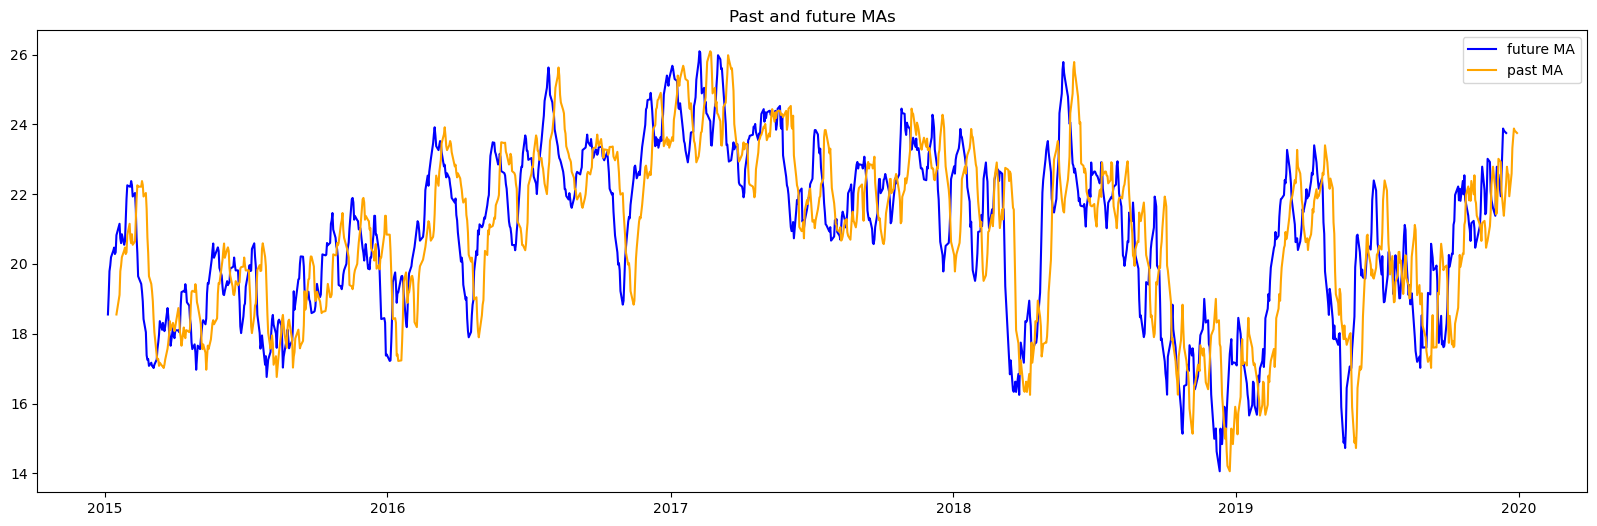

In [8]:
plt.figure(figsize=(20, 6))
plt.plot(portfolio_df_sent['sentiment_ma_next_10'], color = 'blue', label='future MA')
plt.plot(portfolio_df_sent['moving_average_10day'], color = 'orange', label='past MA')
plt.title('Past and future MAs')
plt.legend()
plt.show()

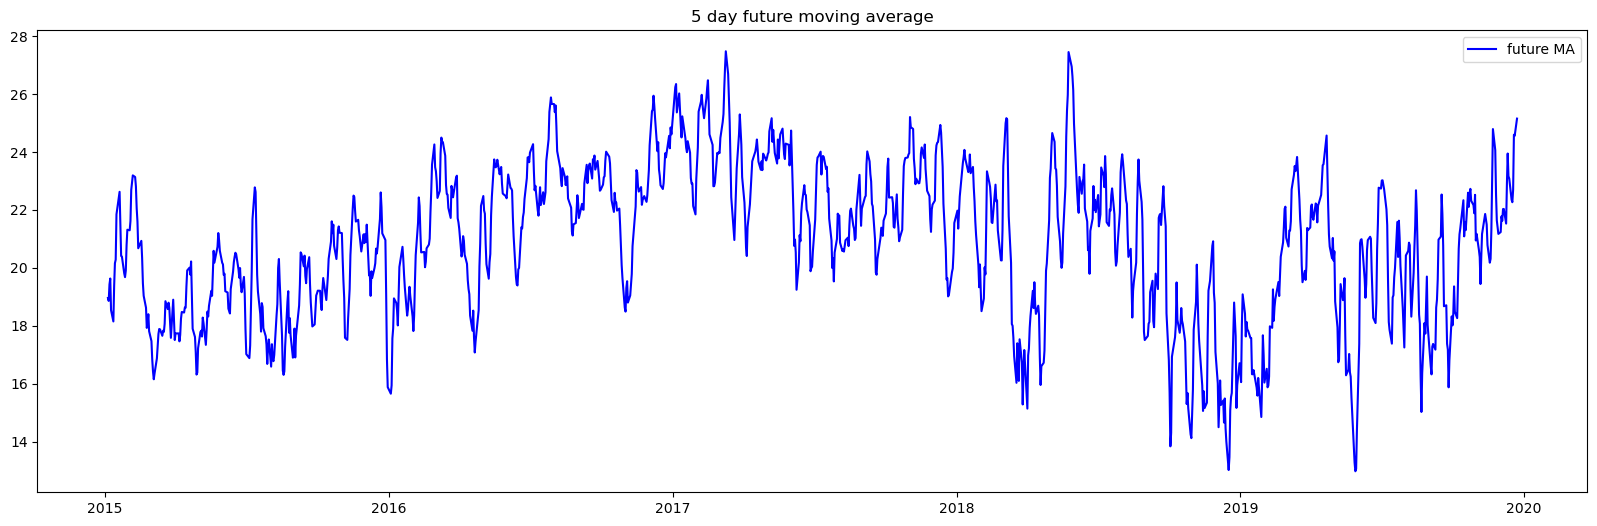

In [9]:
plt.figure(figsize=(20, 6))
plt.plot(portfolio_df_sent['sentiment_ma_next_5'], color = 'blue', label='future MA')
#plt.plot(portfolio_df_sent['moving_average_10day'], color = 'orange', label='past MA')
plt.title('5 day future moving average')
plt.legend()
plt.show()

In [10]:
# ma_past = portfolio_df_sent.copy()
# ma_past = ma_past.drop(columns='sentiment_ma_next_10')
# ma_past = ma_past.dropna()

ma_future = portfolio_df_sent.copy()
ma_future = ma_future[ma_future['sentiment_ma_next_10'].notna()]




In [11]:
# ma_past = portfolio_df_sent.copy()
# ma_past = ma_past.drop(columns='sentiment_ma_next_10')
# ma_past = ma_past.dropna()

ma_future_5day = portfolio_df_sent.copy()
ma_future_5day = ma_future_5day[ma_future_5day['sentiment_ma_next_5'].notna()]

In [12]:
# ma_past = portfolio_df_sent.copy()
# ma_past = ma_past.drop(columns='sentiment_ma_next_10')
# ma_past = ma_past.dropna()

ma_future_15day = portfolio_df_sent.copy()
ma_future_15day = ma_future_15day[ma_future_15day['sentiment_ma_next_15'].notna()]
ma_future_15day = ma_future_15day[ma_future_15day['moving_average_15day'].notna()]

In [13]:
ma_future_15day

r_ndq      r_rf  Volatility  rf_rate      daily_rf  \
Date                                                                
2015-01-26 -0.001151 -0.002288       14.76     0.03  1.200000e-06   
2015-01-27 -0.025926  0.001376       16.70     0.02  8.000000e-07   
2015-01-28 -0.005127  0.007697       18.41     0.02  8.000000e-07   
2015-01-29  0.009612 -0.003546       17.69     0.03  1.200000e-06   
2015-01-30 -0.007754  0.008760       19.51     0.02  8.000000e-07   
...              ...       ...         ...      ...           ...   
2019-12-03 -0.007832  0.008918       16.73     1.57  6.280000e-05   
2019-12-04  0.005064 -0.003840       16.03     1.55  6.200000e-05   
2019-12-05  0.001976 -0.002330       15.91     1.54  6.160000e-05   
2019-12-06  0.010698 -0.003055       14.24     1.53  6.120000e-05   
2019-12-09 -0.004536  0.000811       15.47     1.54  6.160000e-05   

            sentiment_score  sentiment_slope  moving_average_10day  \
Date                                                                 
2015-01-26        21.159589        -0.132005             20.385270   
2015-01-27        18.867201         0.731719             20.468942   
2015-01-28        17.944975        -1.154949             20.283600   
2015-01-29        19.856967        -1.025375             20.333143   
2015-01-30        21.185382        -1.854652             20.824650   
...                     ...              ...                   ...   
2019-12-03        18.238818         1.634640             21.423488   
2019-12-04        21.189866         0.679249             21.466538   
2019-12-05        23.128942         0.306853             22.112304   
2019-12-06        26.900139         0.724123             23.012254   
2019-12-09        19.421242         0.551820             22.920233   

            moving_average_5day  moving_average_20day  moving_average_30day  \
Date                                                                          
2015-01-26            22.623707                   NaN                   NaN   
2015-01-27            21.568785                   NaN                   NaN   
2015-01-28            20.408136                   NaN                   NaN   
2015-01-29            20.385685                   NaN                   NaN   
2015-01-30            19.802823                   NaN                   NaN   
...                         ...                   ...                   ...   
2019-12-03            22.536077             21.328677             21.678208   
2019-12-04            21.634521             21.243004             21.493753   
2019-12-05            21.170685             21.288563             21.705674   
2019-12-06            21.233339             21.796196             21.809061   
2019-12-09            21.775802             21.795768             21.778773   

            moving_average_15day  sentiment_ma_next_10  sentiment_ma_next_5  \
Date                                                                          
2015-01-26             19.909132             20.548913            19.802823   
2015-01-27             19.931424             20.646944            19.677714   
2015-01-28             19.997695             21.297770            19.903704   
2015-01-29             20.098622             21.858354            20.783462   
2015-01-30             20.062387             22.253246            21.315424   
...                          ...                   ...                  ...   
2019-12-03             21.568267             22.340749            21.775802   
2019-12-04             21.532776             22.785276            21.624551   
2019-12-05             21.904879             22.596782            22.028123   
2019-12-06             22.269390             22.556289            22.031570   
2019-12-09             22.005816             21.938549            21.526834   

            sentiment_ma_next_15  
Date                              
2015-01-26             21.411401  
2015-01-27             21.368789  
2015-01-28

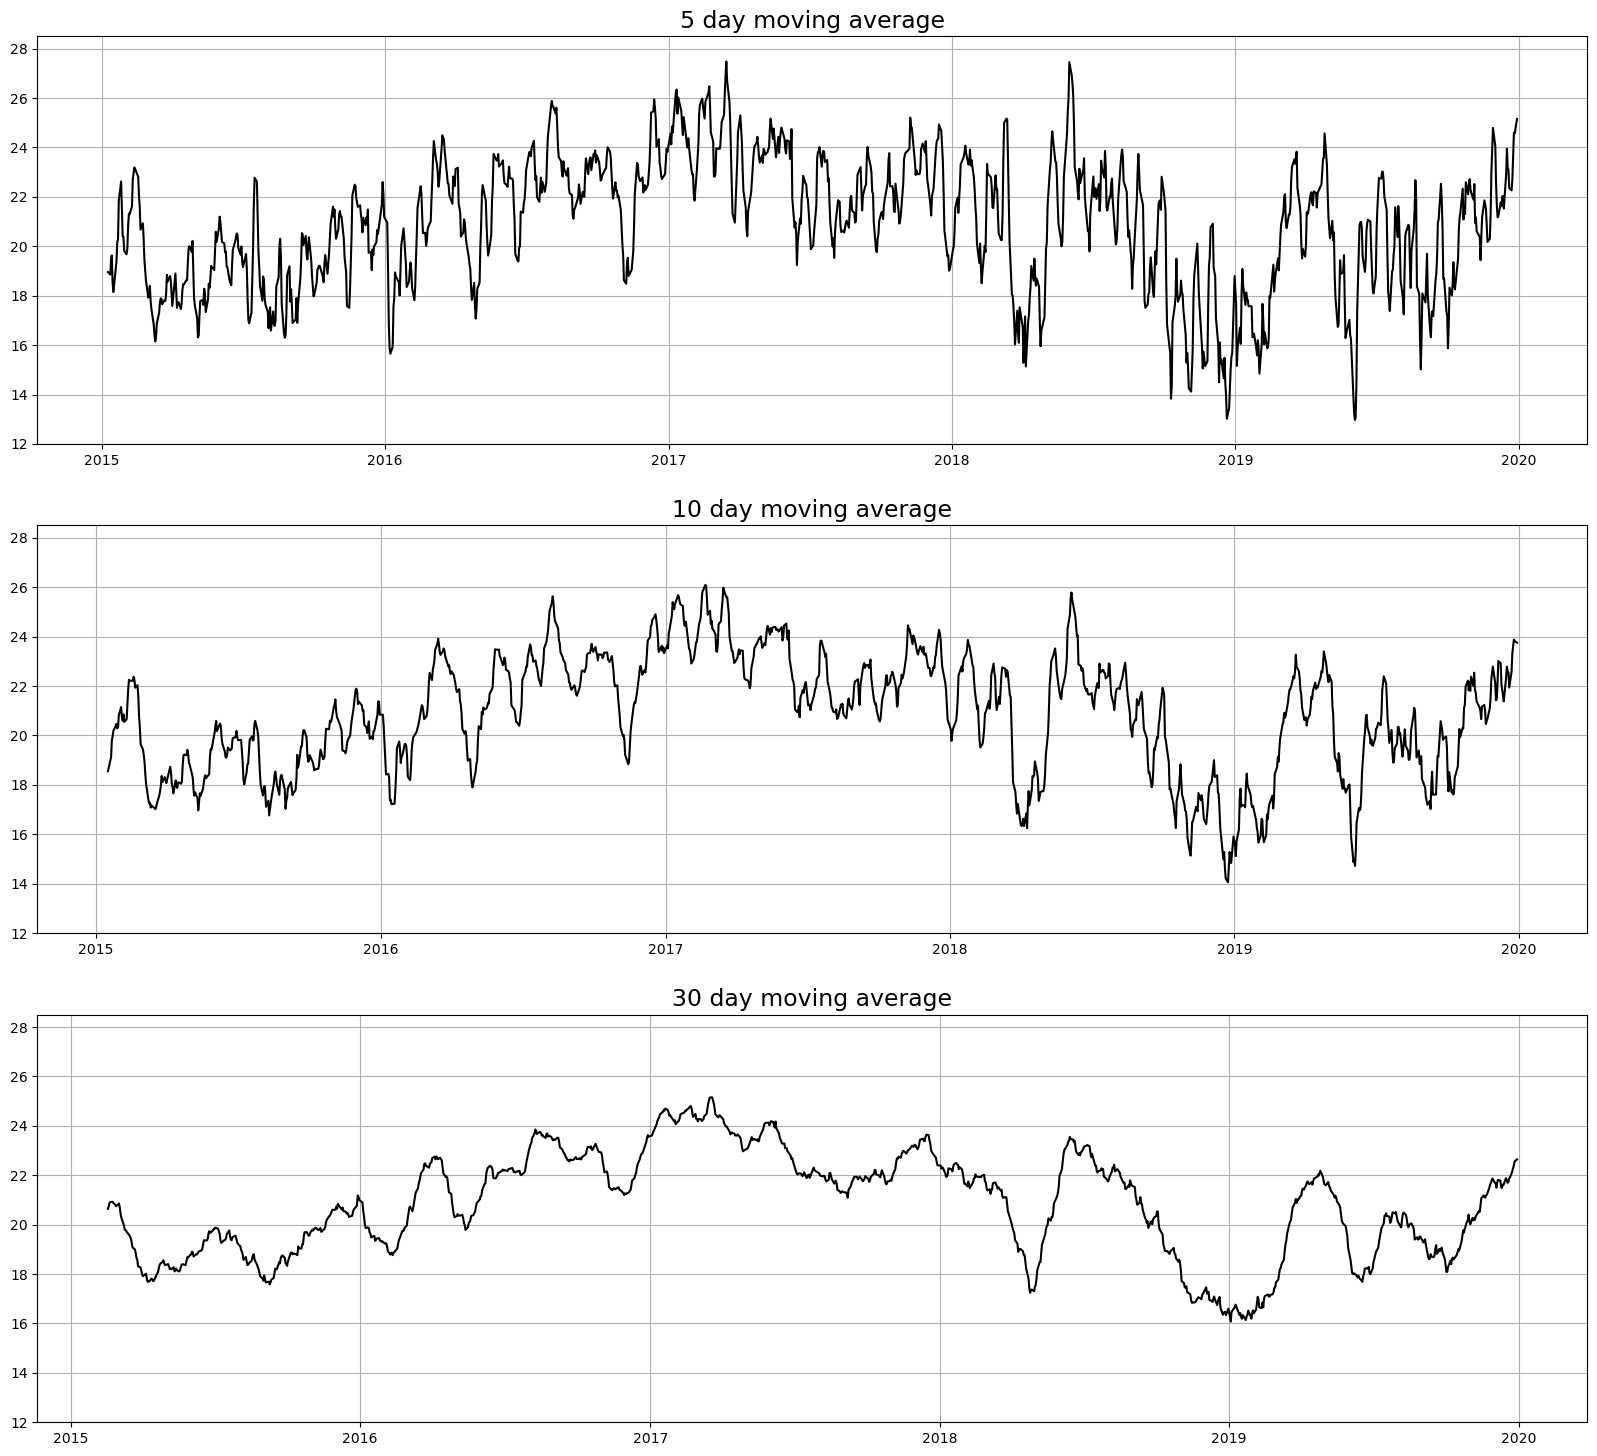

In [14]:
plt.figure(figsize=(20, 18))
plt.subplot(3,1,1)
plt.plot(portfolio_df_sent['moving_average_5day'], label='5 day MA', color = 'black')
#plt.plot(portfolio_df_sent['moving_average_10day'], color = 'orange', label='past MA')
plt.title('5 day moving average', fontdict={'fontsize': 17})
plt.ylim((12,28.5))
plt.grid(True)
#plt.legend()
#plt.show()
#plt.figure(figsize=(20, 6))
plt.subplot(3,1,2)
plt.plot(portfolio_df_sent['moving_average_10day'], label='10 day MA', color = 'black')
#plt.plot(portfolio_df_sent['moving_average_10day'], color = 'orange', label='past MA')
plt.title('10 day moving average', fontdict={'fontsize': 17})
plt.ylim((12,28.5))
plt.grid(True)
#plt.legend()
#plt.show()
#plt.figure(figsize=(20, 6))
plt.subplot(3,1,3)
plt.plot(portfolio_df_sent['moving_average_30day'], label='15 day MA', color='black')
#plt.plot(portfolio_df_sent['moving_average_10day'], color = 'orange', label='past MA')
plt.title('30 day moving average', fontdict={'fontsize': 17})
plt.ylim((12,28.5))
plt.grid(True)
#plt.legend()
plt.show()

## Define new correct sharpe function for future MA

In [15]:
def sharpe_correct(sentiment, version): # version is either sentiment_score or moving_average_10day
    w_ndq = []
    w_rf = []

    # Assuming 'sentiment' is a pandas Series
    
    upper = ma_future[version].shift(1).rolling(63).quantile(0.75) #apply(lambda x: weighted_quantile(x, quantile=0.75), raw=True)
    lower = ma_future[version].shift(1).rolling(63).quantile(0.25) #apply(lambda x: weighted_quantile(x, quantile=0.25), raw=True)
    test_sent = sentiment['2018-07-01':]
    test_df = ma_future['2018-07-01':].copy()
    for i in test_sent.index:
        score = sentiment[i]
        if score > upper[i]: #23: changing to see if it improves
            w_ndq.append(0.8)
            w_rf.append(0.2)
        elif score <= upper[i] and score > lower[i]: # was 20:
            w_ndq.append(0.6)
            w_rf.append(0.4)
        elif score <= lower[i]:
            w_ndq.append(0.2)
            w_rf.append(0.8)
    test_df['w_ndq'] = w_ndq
    test_df['w_rf'] = w_rf
    test_df['r_portfolio'] = test_df['w_ndq'] * test_df['r_ndq'] + test_df['w_rf'] * test_df['r_rf']
    test_df['excess returns'] = test_df['r_portfolio'] - test_df['daily_rf']
    test_df['trading day'] = (test_df['w_ndq'] != test_df['w_ndq'].shift(1)).astype(int)
    
    test_df.reset_index(inplace=True)
    # Identify maximum index in the dataset
    max_index = test_df.index.max()

    # Initialize starting portfolio value
    initial_portfolio_value = 1

    # Create a new DataFrame to store calculated values
    df_calc = pd.DataFrame(index=test_df.index, columns=['portfolio_value', 'ndq_start', 'rf_start', 'ndq_end', 'rf_end'])
    
    # Initialize first values from row 0
    df_calc.loc[0, 'portfolio_value'] = initial_portfolio_value
    df_calc.loc[0, 'ndq_start'] = 0
    df_calc.loc[0, 'rf_start'] = 0
    df_calc.loc[0, 'ndq_end'] = w_ndq[0] * initial_portfolio_value
    df_calc.loc[0, 'rf_end'] = w_rf[0] * initial_portfolio_value

    # Loop through rows from 1 to max_index to calculate the required columns
    for i in range(1, max_index + 1):
        # Calculate ndq_start and rf_start
        df_calc.loc[i, 'ndq_start'] = df_calc.loc[i - 1, 'ndq_end'] * (1 + test_df.loc[i, 'r_ndq'])
        df_calc.loc[i, 'rf_start'] = df_calc.loc[i - 1, 'rf_end'] * (1 + test_df.loc[i, 'r_rf'])

        # Calculate the new portfolio value
        df_calc.loc[i, 'portfolio_value'] = df_calc.loc[i, 'ndq_start'] + df_calc.loc[i, 'rf_start']

        # Calculate ndq_end and rf_end based on updated portfolio value
        df_calc.loc[i, 'ndq_end'] =  w_ndq[i] * df_calc.loc[i, 'portfolio_value']
        df_calc.loc[i, 'rf_end'] = w_rf[i] * df_calc.loc[i, 'portfolio_value']
    
    return2019 = (df_calc['portfolio_value'][-1:]/df_calc['portfolio_value'][0]) **(1/(365/250)) - 1
    risk_free2019 = test_df['rf_rate'].mean()/100
    std2019 = np.std(test_df['excess returns'])*np.sqrt(250)

    test_df.set_index('Date', inplace=True)
    
    return (return2019 - risk_free2019)/std2019, df_calc, test_df, upper, lower



In [16]:
def sharpe_correct_5day(sentiment, version): # version is either sentiment_score or moving_average_10day
    w_ndq = []
    w_rf = []

    # Assuming 'sentiment' is a pandas Series
    
    upper = ma_future_5day[version].shift(1).rolling(63).quantile(0.75) #apply(lambda x: weighted_quantile(x, quantile=0.75), raw=True)
    lower = ma_future_5day[version].shift(1).rolling(63).quantile(0.25) #apply(lambda x: weighted_quantile(x, quantile=0.25), raw=True)
    test_sent = sentiment['2018-07-01':]
    test_df = ma_future_5day['2018-07-01':].copy()
    for i in test_sent.index:
        score = sentiment[i]
        if score > upper[i]: #23: changing to see if it improves
            w_ndq.append(0.8)
            w_rf.append(0.2)
        elif score <= upper[i] and score > lower[i]: # was 20:
            w_ndq.append(0.6)
            w_rf.append(0.4)
        elif score <= lower[i]:
            w_ndq.append(0.2)
            w_rf.append(0.8)
    test_df['w_ndq'] = w_ndq
    test_df['w_rf'] = w_rf
    test_df['r_portfolio'] = test_df['w_ndq'] * test_df['r_ndq'] + test_df['w_rf'] * test_df['r_rf']
    test_df['excess returns'] = test_df['r_portfolio'] - test_df['daily_rf']
    test_df['trading day'] = (test_df['w_ndq'] != test_df['w_ndq'].shift(1)).astype(int)
    
    test_df.reset_index(inplace=True)
    # Identify maximum index in the dataset
    max_index = test_df.index.max()

    # Initialize starting portfolio value
    initial_portfolio_value = 1

    # Create a new DataFrame to store calculated values
    df_calc = pd.DataFrame(index=test_df.index, columns=['portfolio_value', 'ndq_start', 'rf_start', 'ndq_end', 'rf_end'])
    
    # Initialize first values from row 0
    df_calc.loc[0, 'portfolio_value'] = initial_portfolio_value
    df_calc.loc[0, 'ndq_start'] = 0
    df_calc.loc[0, 'rf_start'] = 0
    df_calc.loc[0, 'ndq_end'] = w_ndq[0] * initial_portfolio_value
    df_calc.loc[0, 'rf_end'] = w_rf[0] * initial_portfolio_value

    # Loop through rows from 1 to max_index to calculate the required columns
    for i in range(1, max_index + 1):
        # Calculate ndq_start and rf_start
        df_calc.loc[i, 'ndq_start'] = df_calc.loc[i - 1, 'ndq_end'] * (1 + test_df.loc[i, 'r_ndq'])
        df_calc.loc[i, 'rf_start'] = df_calc.loc[i - 1, 'rf_end'] * (1 + test_df.loc[i, 'r_rf'])

        # Calculate the new portfolio value
        df_calc.loc[i, 'portfolio_value'] = df_calc.loc[i, 'ndq_start'] + df_calc.loc[i, 'rf_start']

        # Calculate ndq_end and rf_end based on updated portfolio value
        df_calc.loc[i, 'ndq_end'] =  w_ndq[i] * df_calc.loc[i, 'portfolio_value']
        df_calc.loc[i, 'rf_end'] = w_rf[i] * df_calc.loc[i, 'portfolio_value']
    
    return2019 = (df_calc['portfolio_value'][-1:]/df_calc['portfolio_value'][0]) **(1/(365/250)) - 1
    risk_free2019 = test_df['rf_rate'].mean()/100
    std2019 = np.std(test_df['excess returns'])*np.sqrt(250)

    test_df.set_index('Date', inplace=True)
    
    return (return2019 - risk_free2019)/std2019, df_calc, test_df, upper, lower



In [17]:
def sharpe_correct_15day(sentiment, version): # version is either sentiment_score or moving_average_10day
    w_ndq = []
    w_rf = []

    # Assuming 'sentiment' is a pandas Series
    
    upper = ma_future_15day[version].shift(1).rolling(63).quantile(0.75) #apply(lambda x: weighted_quantile(x, quantile=0.75), raw=True)
    lower = ma_future_15day[version].shift(1).rolling(63).quantile(0.25) #apply(lambda x: weighted_quantile(x, quantile=0.25), raw=True)
    test_sent = sentiment['2018-07-01':]
    test_df = ma_future_15day['2018-07-01':].copy()
    for i in test_sent.index:
        score = sentiment[i]
        if score > upper[i]: #23: changing to see if it improves
            w_ndq.append(0.8)
            w_rf.append(0.2)
        elif score <= upper[i] and score > lower[i]: # was 20:
            w_ndq.append(0.6)
            w_rf.append(0.4)
        elif score <= lower[i]:
            w_ndq.append(0.2)
            w_rf.append(0.8)
    test_df['w_ndq'] = w_ndq
    test_df['w_rf'] = w_rf
    test_df['r_portfolio'] = test_df['w_ndq'] * test_df['r_ndq'] + test_df['w_rf'] * test_df['r_rf']
    test_df['excess returns'] = test_df['r_portfolio'] - test_df['daily_rf']
    test_df['trading day'] = (test_df['w_ndq'] != test_df['w_ndq'].shift(1)).astype(int)
    
    test_df.reset_index(inplace=True)
    # Identify maximum index in the dataset
    max_index = test_df.index.max()

    # Initialize starting portfolio value
    initial_portfolio_value = 1

    # Create a new DataFrame to store calculated values
    df_calc = pd.DataFrame(index=test_df.index, columns=['portfolio_value', 'ndq_start', 'rf_start', 'ndq_end', 'rf_end'])
    
    # Initialize first values from row 0
    df_calc.loc[0, 'portfolio_value'] = initial_portfolio_value
    df_calc.loc[0, 'ndq_start'] = 0
    df_calc.loc[0, 'rf_start'] = 0
    df_calc.loc[0, 'ndq_end'] = w_ndq[0] * initial_portfolio_value
    df_calc.loc[0, 'rf_end'] = w_rf[0] * initial_portfolio_value

    # Loop through rows from 1 to max_index to calculate the required columns
    for i in range(1, max_index + 1):
        # Calculate ndq_start and rf_start
        df_calc.loc[i, 'ndq_start'] = df_calc.loc[i - 1, 'ndq_end'] * (1 + test_df.loc[i, 'r_ndq'])
        df_calc.loc[i, 'rf_start'] = df_calc.loc[i - 1, 'rf_end'] * (1 + test_df.loc[i, 'r_rf'])

        # Calculate the new portfolio value
        df_calc.loc[i, 'portfolio_value'] = df_calc.loc[i, 'ndq_start'] + df_calc.loc[i, 'rf_start']

        # Calculate ndq_end and rf_end based on updated portfolio value
        df_calc.loc[i, 'ndq_end'] =  w_ndq[i] * df_calc.loc[i, 'portfolio_value']
        df_calc.loc[i, 'rf_end'] = w_rf[i] * df_calc.loc[i, 'portfolio_value']
    
    return2019 = (df_calc['portfolio_value'][-1:]/df_calc['portfolio_value'][0]) **(1/(365/250)) - 1
    risk_free2019 = test_df['rf_rate'].mean()/100
    std2019 = np.std(test_df['excess returns'])*np.sqrt(250)

    test_df.set_index('Date', inplace=True)
    
    return (return2019 - risk_free2019)/std2019, df_calc, test_df, upper, lower



## Sharpe with 60/40 benchmark: 1.045 (code in risk_adjusted_returns file)

## Sharpe with actual sentiment score

In [18]:
ma_future

r_ndq      r_rf  Volatility  rf_rate      daily_rf  \
Date                                                                
2015-01-05 -0.014669  0.006101       18.00     0.03  1.200000e-06   
2015-01-06 -0.013408  0.006718       19.05     0.03  1.200000e-06   
2015-01-07  0.012891 -0.000186       17.20     0.03  1.200000e-06   
2015-01-08  0.019140 -0.004079       16.61     0.03  1.200000e-06   
2015-01-09 -0.006583  0.004933       16.60     0.02  8.000000e-07   
...              ...       ...         ...      ...           ...   
2019-12-10 -0.000833 -0.001171       15.51     1.56  6.240000e-05   
2019-12-11  0.005297  0.004147       14.77     1.57  6.280000e-05   
2019-12-12  0.007464 -0.007900       14.12     1.56  6.240000e-05   
2019-12-13  0.003293  0.005882       12.55     1.57  6.280000e-05   
2019-12-16  0.010039 -0.004678       11.73     1.57  6.280000e-05   

            sentiment_score  sentiment_slope  moving_average_10day  \
Date                                                                 
2015-01-05        18.532825        -1.688521                   NaN   
2015-01-06        16.950898        -0.425215                   NaN   
2015-01-07        18.343075        -1.852799                   NaN   
2015-01-08        21.728897         0.104260                   NaN   
2015-01-09        19.228589        -2.596250                   NaN   
...                     ...              ...                   ...   
2019-12-10        17.482563         1.564996             22.080314   
2019-12-11        23.207731         0.405708             21.831322   
2019-12-12        23.146175         2.221181             21.601127   
2019-12-13        24.376457        -0.225680             21.380086   
2019-12-16        26.315553         0.905148             22.340749   

            moving_average_5day  moving_average_20day  moving_average_30day  \
Date                                                                          
2015-01-05                  NaN                   NaN                   NaN   
2015-01-06                  NaN                   NaN                   NaN   
2015-01-07                  NaN                   NaN                   NaN   
2015-01-08                  NaN                   NaN                   NaN   
2015-01-09            18.956857                   NaN                   NaN   
...                         ...                   ...                   ...   
2019-12-10            21.624551             21.582338             21.516935   
2019-12-11            22.028123             21.656613             21.480797   
2019-12-12            22.031570             21.936552             21.617484   
2019-12-13            21.526834             22.083751             21.609202   
2019-12-16            22.905696             22.230786             21.876717   

            moving_average_15day  sentiment_ma_next_10  sentiment_ma_next_5  \
Date                                                                          
2015-01-05                   NaN             18.551844            18.956857   
2015-01-06                   NaN             19.112743            18.856387   
2015-01-07                   NaN             19.792475            19.425886   
2015-01-08                   NaN             19.955090            19.629579   
2015-01-09                   NaN             20.192170            18.537863   
...                          ...                   ...                  ...   
2019-12-10             21.490509             22.584993            22.905696   
2019-12-11             21.653733             23.320627            23.946002   
2019-12-12             22.085393             23.880173            23.165440   
2019-12-13             22.517114             23.819605            23.081009   
2019-12-16             22.915387             23.751206            22.350264   

            sentiment_ma_next_15  
Date                              
2015-01-05             19.909132  
2015-01-06             19.931424  
2015-01-07

In [19]:
sharpe_act, df_calc_act, test_df_act, upper_act, lower_act = sharpe_correct(ma_future['sentiment_score'], 'sentiment_score')
print(sharpe_act)
print(test_df_act['trading day'].sum())


363    1.78273
Name: portfolio_value, dtype: object
199


## Sharpe with future sentiment

In [20]:
sharpe_act_future_ma, df_calc_act_future_ma, test_df_act_future_ma, upper_act_future_ma, lower_act_future_ma = sharpe_correct(ma_future['sentiment_ma_next_10'], 'sentiment_score')
print(sharpe_act_future_ma)
print(test_df_act_future_ma['trading day'].sum())


363    2.329288
Name: portfolio_value, dtype: object
42


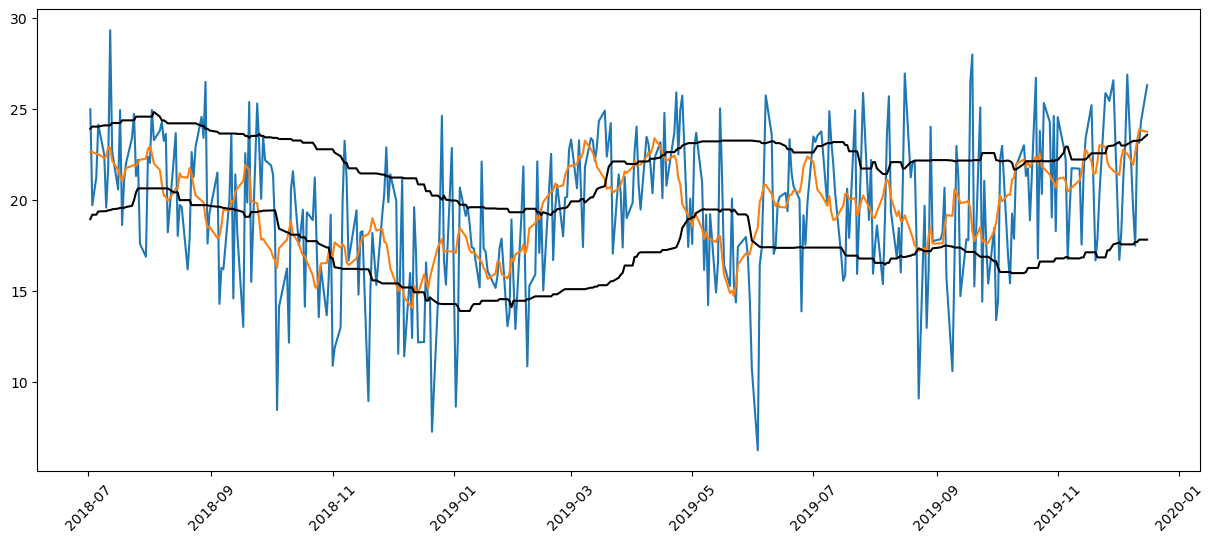

In [21]:
plt.figure(figsize=(15, 6))
plt.plot(ma_future['sentiment_score']['2018-07-01':])
plt.plot(ma_future['sentiment_ma_next_10']['2018-07-01':])
plt.plot(upper_act_future_ma['2018-07-01':], color = 'black')
plt.plot(lower_act_future_ma['2018-07-01':], color = 'black')
plt.xticks(rotation=45) 
plt.show()

In [22]:
sharpe_act_future_ma, df_calc_act_future_ma, test_df_act_future_ma, upper_act_future_ma, lower_act_future_ma = sharpe_correct(ma_future['sentiment_ma_next_10'], 'sentiment_ma_next_10')
print(sharpe_act_future_ma)
print(test_df_act_future_ma['trading day'].sum())


363    3.413475
Name: portfolio_value, dtype: object
54


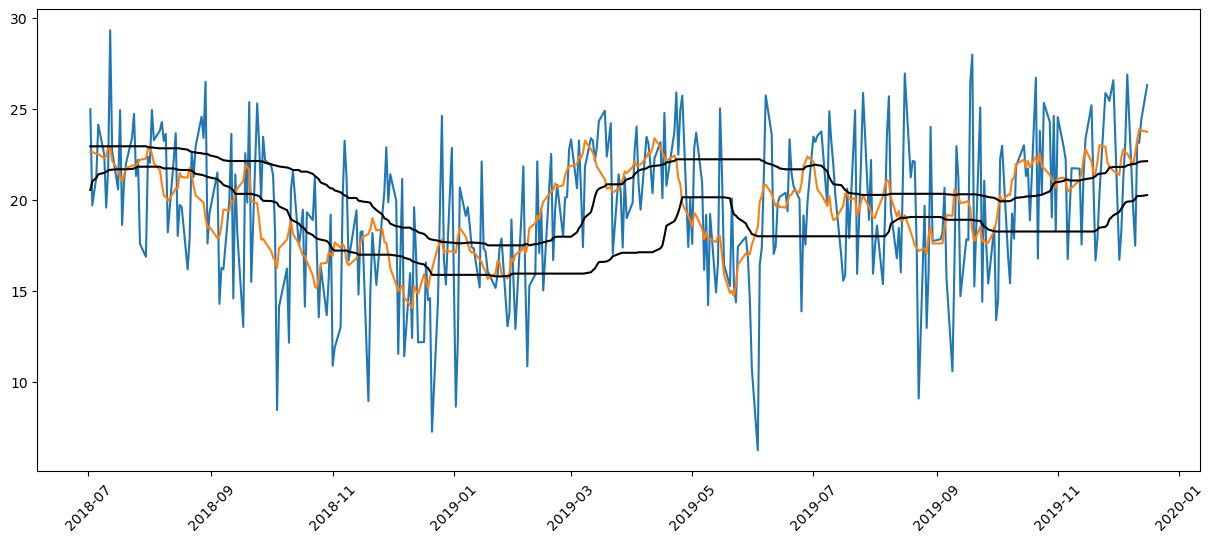

In [23]:
plt.figure(figsize=(15, 6))
plt.plot(ma_future['sentiment_score']['2018-07-01':])
plt.plot(ma_future['sentiment_ma_next_10']['2018-07-01':])
plt.plot(upper_act_future_ma['2018-07-01':], color = 'black')
plt.plot(lower_act_future_ma['2018-07-01':], color = 'black')
plt.xticks(rotation=45) 
plt.show()

In [24]:
sharpe_act_future_ma, df_calc_act_future_ma, test_df_act_future_ma, upper_act_future_ma, lower_act_future_ma = sharpe_correct(ma_future['sentiment_ma_next_10'], 'moving_average_10day')
print(sharpe_act_future_ma)
print(test_df_act_future_ma['trading day'].sum())


363    3.426316
Name: portfolio_value, dtype: object
34


In [25]:
sharpe_act_future_ma, df_calc_act_future_ma, test_df_act_future_ma, upper_act_future_ma, lower_act_future_ma = sharpe_correct(ma_future['sentiment_ma_next_10'], 'moving_average_20day')
print(sharpe_act_future_ma)
print(test_df_act_future_ma['trading day'].sum())


363    3.442417
Name: portfolio_value, dtype: object
32


In [26]:
ma_future_5day

r_ndq      r_rf  Volatility  rf_rate      daily_rf  \
Date                                                                
2015-01-05 -0.014669  0.006101       18.00     0.03  1.200000e-06   
2015-01-06 -0.013408  0.006718       19.05     0.03  1.200000e-06   
2015-01-07  0.012891 -0.000186       17.20     0.03  1.200000e-06   
2015-01-08  0.019140 -0.004079       16.61     0.03  1.200000e-06   
2015-01-09 -0.006583  0.004933       16.60     0.02  8.000000e-07   
...              ...       ...         ...      ...           ...   
2019-12-17  0.000573  0.000090       11.79     1.56  6.240000e-05   
2019-12-18  0.000764 -0.002711       11.95     1.56  6.240000e-05   
2019-12-19  0.006251  0.000780       11.73     1.57  6.280000e-05   
2019-12-20  0.004031  0.000000       11.78     1.58  6.320000e-05   
2019-12-23  0.002641 -0.000906       12.34     1.59  6.360000e-05   

            sentiment_score  sentiment_slope  moving_average_10day  \
Date                                                                 
2015-01-05        18.532825        -1.688521                   NaN   
2015-01-06        16.950898        -0.425215                   NaN   
2015-01-07        18.343075        -1.852799                   NaN   
2015-01-08        21.728897         0.104260                   NaN   
2015-01-09        19.228589        -2.596250                   NaN   
...                     ...              ...                   ...   
2019-12-17        22.684092         0.136037             22.785276   
2019-12-18        19.304922         0.904915             22.596782   
2019-12-19        22.724018         1.056231             22.556289   
2019-12-20        20.722737        -2.102416             21.938549   
2019-12-23        25.885680        -0.659049             22.584993   

            moving_average_5day  moving_average_20day  moving_average_30day  \
Date                                                                          
2015-01-05                  NaN                   NaN                   NaN   
2015-01-06                  NaN                   NaN                   NaN   
2015-01-07                  NaN                   NaN                   NaN   
2015-01-08                  NaN                   NaN                   NaN   
2015-01-09            18.956857                   NaN                   NaN   
...                         ...                   ...                   ...   
2019-12-17            23.946002             22.104382             21.814210   
2019-12-18            23.165440             22.031660             21.694263   
2019-12-19            23.081009             22.334297             21.711138   
2019-12-20            22.350264             22.475402             21.843647   
2019-12-23            22.264290             22.752613             22.058843   

            moving_average_15day  sentiment_ma_next_10  sentiment_ma_next_5  \
Date                                                                          
2015-01-05                   NaN             18.551844            18.956857   
2015-01-06                   NaN             19.112743            18.856387   
2015-01-07                   NaN             19.792475            19.425886   
2015-01-08                   NaN             19.955090            19.629579   
2015-01-09                   NaN             20.192170            18.537863   
...                          ...                   ...                  ...   
2019-12-17             22.702210                   NaN            22.264290   
2019-12-18             22.276028                   NaN            22.695252   
2019-12-19             22.094421                   NaN            24.594906   
2019-12-20             21.703479                   NaN            24.558201   
2019-12-23             22.315262                   NaN            25.152148   

            sentiment_ma_next_15  
Date                              
2015-01-05             19.909132  
2015-01-06             19.931424  
2015-01-07

In [27]:
sharpe_act_future_ma_5day, df_calc_act_future_ma_5day, test_df_act_future_ma_5day, upper_act_future_ma_5day, lower_act_future_ma_5day = sharpe_correct_5day(ma_future_5day['sentiment_ma_next_5'], 'moving_average_10day')
print(sharpe_act_future_ma_5day)
print(test_df_act_future_ma_5day['trading day'].sum())


368    4.411424
Name: portfolio_value, dtype: object
73


In [28]:
sharpe_act_future_ma_5day, df_calc_act_future_ma_5day, test_df_act_future_ma_5day, upper_act_future_ma_5day, lower_act_future_ma_5day = sharpe_correct_5day(ma_future_5day['sentiment_ma_next_5'], 'moving_average_5day')
print(sharpe_act_future_ma_5day)
print(test_df_act_future_ma_5day['trading day'].sum())


368    4.365431
Name: portfolio_value, dtype: object
78


In [29]:
sharpe_act_future_ma_15day, df_calc_act_future_ma_15day, test_df_act_future_ma_15day, upper_act_future_ma_15day, lower_act_future_ma_15day = sharpe_correct_15day(ma_future_15day['sentiment_ma_next_15'], 'moving_average_15day')
print(sharpe_act_future_ma_15day)
print(test_df_act_future_ma_15day['trading day'].sum())


358    3.068881
Name: portfolio_value, dtype: object
26


In [30]:
sharpe_act_future_ma_15day, df_calc_act_future_ma_15day, test_df_act_future_ma_15day, upper_act_future_ma_15day, lower_act_future_ma_15day = sharpe_correct_15day(ma_future_15day['sentiment_ma_next_15'], 'moving_average_30day')
print(sharpe_act_future_ma_15day)
print(test_df_act_future_ma_15day['trading day'].sum())


358    3.075126
Name: portfolio_value, dtype: object
24


In [31]:
sharpe_act, df_calc_act, test_df_act, upper_act, lower_act = sharpe_correct_5day(ma_future_5day['sentiment_score'], 'sentiment_score')
print(sharpe_act)
print(test_df_act['trading day'].sum())


368    1.859024
Name: portfolio_value, dtype: object
201


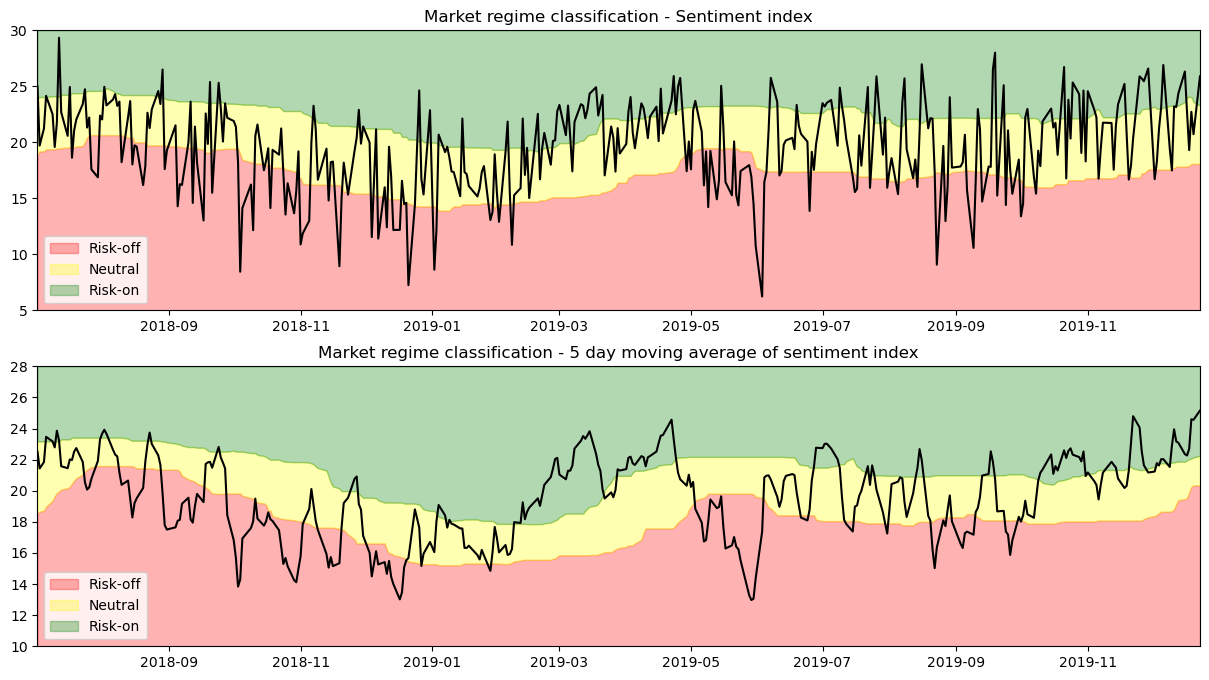

In [32]:
plt.figure(figsize=(15,8))
# Plotting the price data on t
plt.subplot(2,1,1)
plt.plot(ma_future_5day['sentiment_score']['2018-07-01':], color = 'black', linestyle='-')  # Plot the sentiment score
#plt.scatter(ma_future['sentiment_score']['2018-07-01':].index, ma_future['sentiment_score']['2018-07-01':], s=5, color='gray')  # Plot the sentiment score
#plt.legend(loc='upper right')  # Place a legend in the upper right corner
plt.fill_between(x = ma_future_5day['2018-07-01':].index, y1 = 5, y2 = lower_act['2018-07-01':], alpha = 0.3, color = 'red', label='Risk-off')
plt.fill_between(x = ma_future_5day['2018-07-01':].index, y1 = lower_act['2018-07-01':], y2 =upper_act['2018-07-01':], alpha = 0.3, color = 'yellow', label='Neutral')
plt.fill_between(x = ma_future_5day['2018-07-01':].index, y1 = upper_act['2018-07-01':], y2 = 30, alpha = 0.3, color = 'green', label='Risk-on')
plt.title('Market regime classification - Sentiment index')
plt.xlim(ma_future_5day['2018-07-01':].index.min(), ma_future_5day.index.max())
plt.ylim(5,30)
plt.legend()

plt.subplot(2,1,2)
plt.plot(ma_future_5day['sentiment_ma_next_5']['2018-07-01':], color = 'black')  # Plot the sentiment score
#plt.scatter(ma_future_5day['sentiment_ma_next_5']['2018-07-01':].index, ma_future_5day['sentiment_ma_next_5']['2018-07-01':], s=5, color = 'black')  # Plot the sentiment score
#plt.legend(loc='upper right')  # Place a legend in the upper right corner
plt.fill_between(x = ma_future_5day['2018-07-01':].index, y1 = 10, y2 = lower_act_future_ma_5day['2018-07-01':], alpha = 0.3, color = 'red', label='Risk-off')
plt.fill_between(x = ma_future_5day['2018-07-01':].index, y1 = lower_act_future_ma_5day['2018-07-01':], y2 =upper_act_future_ma_5day['2018-07-01':], alpha = 0.3, color = 'yellow', label='Neutral')
plt.fill_between(x = ma_future_5day['2018-07-01':].index, y1 = upper_act_future_ma_5day['2018-07-01':], y2 = 28, alpha = 0.3, color = 'green', label='Risk-on')
plt.title('Market regime classification - 5 day moving average of sentiment index')
plt.xlim(ma_future_5day['2018-07-01':].index.min(), ma_future_5day.index.max())
plt.ylim(10,28)
plt.legend()


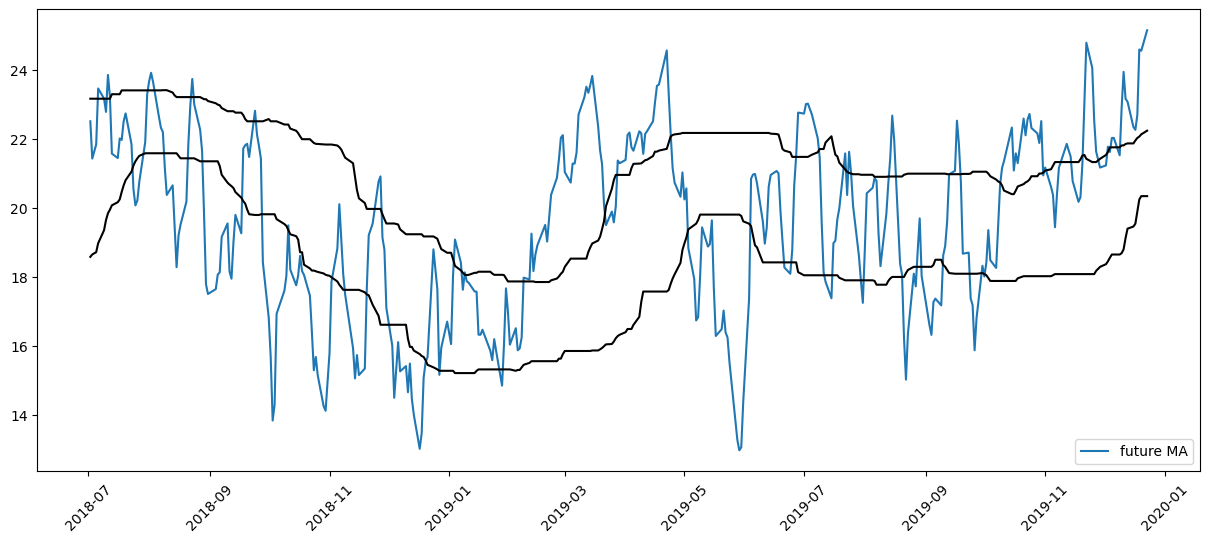

In [33]:
plt.figure(figsize=(15, 6))
#plt.plot(ma_future_5day['moving_average_5day']['2018-07-01':], label = 'past MA')
plt.plot(ma_future_5day['sentiment_ma_next_5']['2018-07-01':], label = 'future MA')
plt.plot(upper_act_future_ma_5day['2018-07-01':], color = 'black')
plt.plot(lower_act_future_ma_5day['2018-07-01':], color = 'black')
plt.xticks(rotation=45)
plt.legend(loc='lower right')
plt.show()

In [34]:
QQQ_df = price_df.copy()
QQQ_df.set_index('Date', inplace=True)

QQQ_df_weekdays_test = QQQ_df[~QQQ_df.index.isin(QQQ_df.index.difference(ma_future.index))]


In [35]:
QQQ_df_weekdays_test

Open        High         Low       Close   Adj Close  \
Date                                                                     
2015-01-05  102.489998  102.610001  101.139999  101.430000   94.300850   
2015-01-06  101.580002  101.750000   99.620003  100.070000   93.036430   
2015-01-07  100.730003  101.599998  100.489998  101.360001   94.235786   
2015-01-08  102.220001  103.500000  102.110001  103.300003   96.039421   
2015-01-09  103.620003  103.650002  102.019997  102.620003   95.407211   
...                ...         ...         ...         ...         ...   
2019-12-10  204.169998  204.880005  203.440002  203.899994  198.230652   
2019-12-11  204.360001  205.190002  204.039993  204.979996  199.280624   
2019-12-12  204.770004  207.320007  204.490005  206.509995  200.768066   
2019-12-13  206.399994  207.910004  205.960007  207.190002  201.429169   
2019-12-16  208.550003  209.529999  208.479996  209.270004  203.451340   

              Volume     r_ndq  
Date                            
2015-01-05  36521300 -0.014669  
2015-01-06  66205500 -0.013408  
2015-01-07  37577400  0.012891  
2015-01-08  40212600  0.019140  
2015-01-09  41410100 -0.006583  
...              ...       ...  
2019-12-10  21799800 -0.000833  
2019-12-11  18780800  0.005297  
2019-12-12  32612000  0.007464  
2019-12-13  32519400  0.003293  
2019-12-16  21296600  0.010039  

[1238 rows x 7 columns]

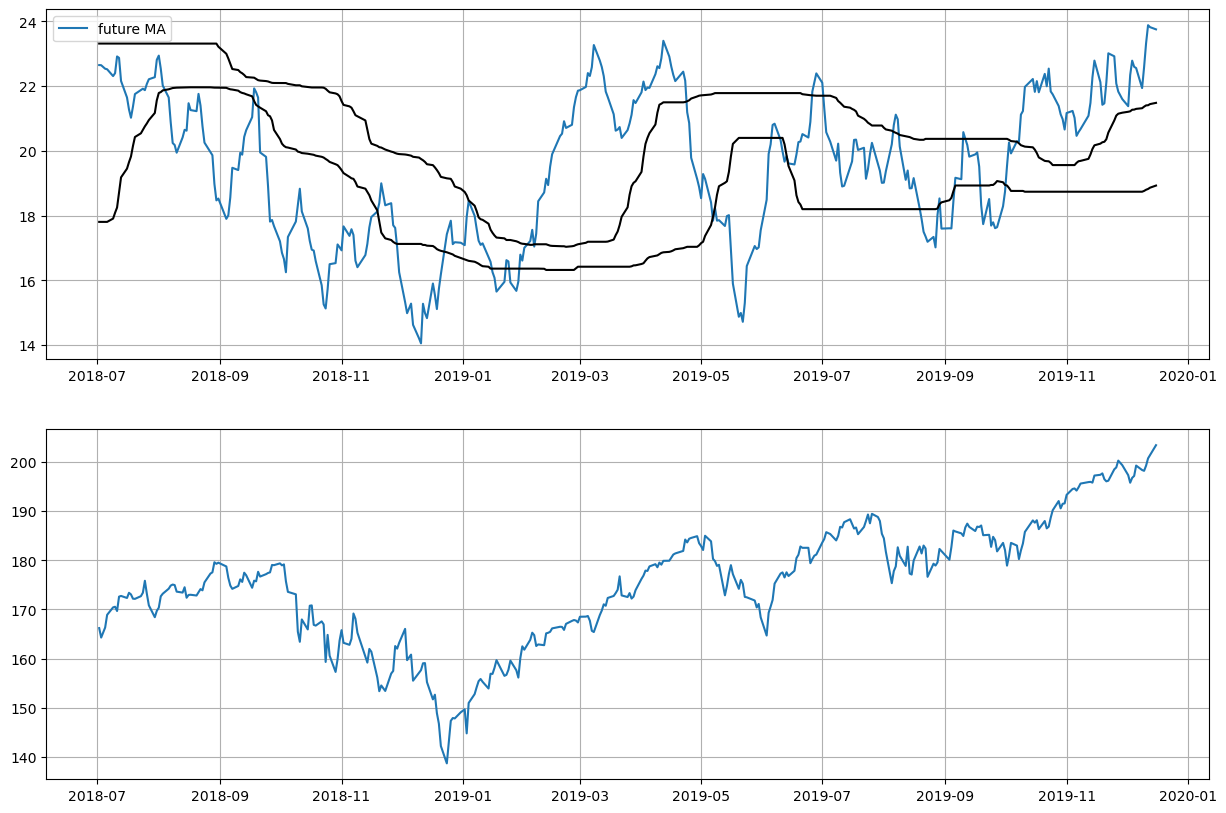

In [36]:
plt.figure(figsize=(15, 10))
plt.subplot(2, 1, 1)
# plt.plot(ma_future['moving_average_10day']['2018-07-01':], label = 'past MA')
plt.plot(ma_future['sentiment_ma_next_10']['2018-07-01':], label = 'future MA')
plt.plot(upper_act_future_ma['2018-07-01':], color = 'black')
plt.plot(lower_act_future_ma['2018-07-01':], color = 'black')
plt.grid(True)
plt.legend()
# plt.xticks(rotation=45)
plt.subplot(2, 1, 2)
plt.plot(QQQ_df_weekdays_test['Adj Close']['2018-07-01':])
plt.grid(True)
plt.show()

In [37]:
#sharpe_act_10d_ma, df_calc_act_10d_ma, test_df_act_10d_ma, upper_act_10d_ma, lower_act_10d_ma = sharpe_correct_exp_disc(portfolio_df_sent['moving_average_10day'], 'moving_average_10day')
#print(sharpe_act_10d_ma)
#print(test_df_act_10d_ma['trading day'].sum())


## Sharpe with ACTUAL LAGGED sentiment index 

In [38]:
ma_future['sentiment_1lag_act'] =  ma_future['sentiment_score'].shift(1)
ma_future['sentiment_2lag_act'] =  ma_future['sentiment_score'].shift(2)
ma_future['sentiment_3lag_act'] =  ma_future['sentiment_score'].shift(3)



In [39]:
ma_future

r_ndq      r_rf  Volatility  rf_rate      daily_rf  \
Date                                                                
2015-01-05 -0.014669  0.006101       18.00     0.03  1.200000e-06   
2015-01-06 -0.013408  0.006718       19.05     0.03  1.200000e-06   
2015-01-07  0.012891 -0.000186       17.20     0.03  1.200000e-06   
2015-01-08  0.019140 -0.004079       16.61     0.03  1.200000e-06   
2015-01-09 -0.006583  0.004933       16.60     0.02  8.000000e-07   
...              ...       ...         ...      ...           ...   
2019-12-10 -0.000833 -0.001171       15.51     1.56  6.240000e-05   
2019-12-11  0.005297  0.004147       14.77     1.57  6.280000e-05   
2019-12-12  0.007464 -0.007900       14.12     1.56  6.240000e-05   
2019-12-13  0.003293  0.005882       12.55     1.57  6.280000e-05   
2019-12-16  0.010039 -0.004678       11.73     1.57  6.280000e-05   

            sentiment_score  sentiment_slope  moving_average_10day  \
Date                                                                 
2015-01-05        18.532825        -1.688521                   NaN   
2015-01-06        16.950898        -0.425215                   NaN   
2015-01-07        18.343075        -1.852799                   NaN   
2015-01-08        21.728897         0.104260                   NaN   
2015-01-09        19.228589        -2.596250                   NaN   
...                     ...              ...                   ...   
2019-12-10        17.482563         1.564996             22.080314   
2019-12-11        23.207731         0.405708             21.831322   
2019-12-12        23.146175         2.221181             21.601127   
2019-12-13        24.376457        -0.225680             21.380086   
2019-12-16        26.315553         0.905148             22.340749   

            moving_average_5day  moving_average_20day  moving_average_30day  \
Date                                                                          
2015-01-05                  NaN                   NaN                   NaN   
2015-01-06                  NaN                   NaN                   NaN   
2015-01-07                  NaN                   NaN                   NaN   
2015-01-08                  NaN                   NaN                   NaN   
2015-01-09            18.956857                   NaN                   NaN   
...                         ...                   ...                   ...   
2019-12-10            21.624551             21.582338             21.516935   
2019-12-11            22.028123             21.656613             21.480797   
2019-12-12            22.031570             21.936552             21.617484   
2019-12-13            21.526834             22.083751             21.609202   
2019-12-16            22.905696             22.230786             21.876717   

            moving_average_15day  sentiment_ma_next_10  sentiment_ma_next_5  \
Date                                                                          
2015-01-05                   NaN             18.551844            18.956857   
2015-01-06                   NaN             19.112743            18.856387   
2015-01-07                   NaN             19.792475            19.425886   
2015-01-08                   NaN             19.955090            19.629579   
2015-01-09                   NaN             20.192170            18.537863   
...                          ...                   ...                  ...   
2019-12-10             21.490509             22.584993            22.905696   
2019-12-11             21.653733             23.320627            23.946002   
2019-12-12             22.085393             23.880173            23.165440   
2019-12-13             22.517114             23.819605            23.081009   
2019-12-16             22.915387             23.751206            22.350264   

            sentiment_ma_next_15  sentiment_1lag_act  sentiment_2lag_act  \
Date                                                                      

In [40]:
sharpe_act_lag, df_calc_act_lag, test_df_act_lag, upper_act_lag, lower_act_lag = sharpe_correct(ma_future['sentiment_1lag_act'], 'sentiment_score')
print(sharpe_act_lag)
print(test_df_act_lag['trading day'].sum())


363    0.429139
Name: portfolio_value, dtype: object
202


In [41]:
sharpe_act_lag_2, df_calc_act_lag_2, test_df_act_lag_2, upper_act_lag_2, lower_act_lag_2 = sharpe_correct(ma_future['sentiment_2lag_act'], 'sentiment_score')
print(sharpe_act_lag_2)
print(test_df_act_lag_2['trading day'].sum())


363    1.408047
Name: portfolio_value, dtype: object
202


In [42]:
sharpe_act_lag_3, df_calc_act_lag_3, test_df_act_lag_3, upper_act_lag_3, lower_act_lag_3 = sharpe_correct(ma_future['sentiment_3lag_act'], 'sentiment_score')
print(sharpe_act_lag_3)
print(test_df_act_lag_3['trading day'].sum())


363    0.639545
Name: portfolio_value, dtype: object
205


For a lag of 2, the results are kinda decent but have way too many trading days.

## ARMA 
#### is not really applicable for future moving average because the most recent lag that we could use would be 10 day lag. More recent lags would include values that we don't actually know yet.

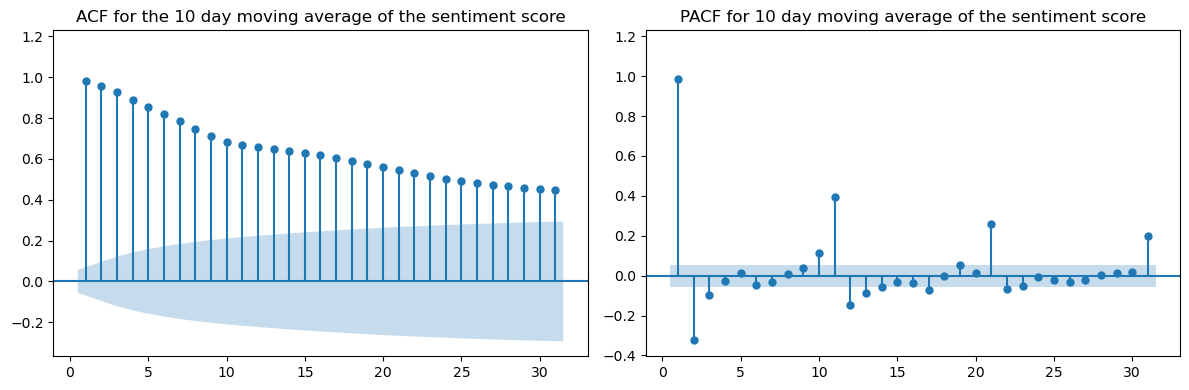

In [43]:
#Plot acf and pacf:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

# ACF plot()
ax1 = plt.subplot(1, 2, 1)
plot_acf(portfolio_df_sent['sentiment_ma_next_10'].dropna(), zero=False, auto_ylims=True, ax=ax1, title='ACF for the 10 day moving average of the sentiment score')

# PACF plot
ax2 = plt.subplot(1, 2, 2)
plot_pacf(portfolio_df_sent['sentiment_ma_next_10'].dropna(), zero=False, auto_ylims=True, ax=ax2, title='PACF for 10 day moving average of the sentiment score')

plt.tight_layout()
plt.show()


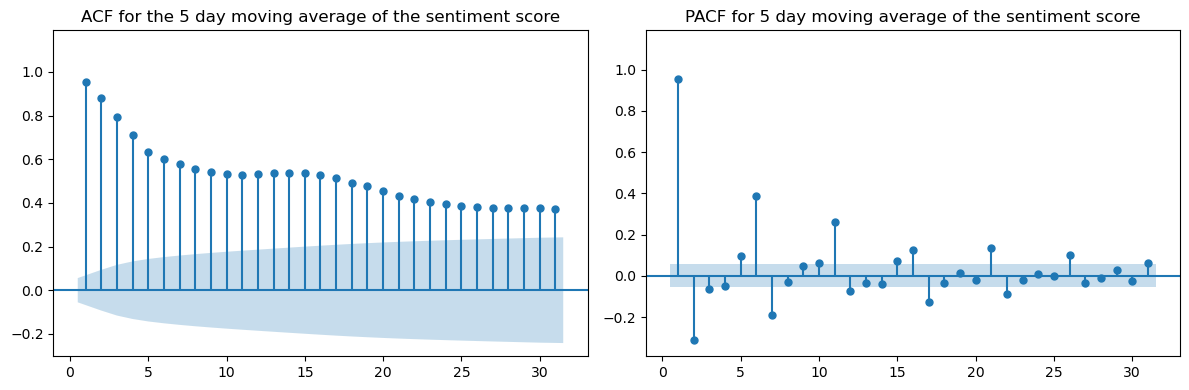

In [44]:
#Plot acf and pacf:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

# ACF plot()
ax1 = plt.subplot(1, 2, 1)
plot_acf(portfolio_df_sent['sentiment_ma_next_5'].dropna(), zero=False, auto_ylims=True, ax=ax1, title='ACF for the 5 day moving average of the sentiment score')

# PACF plot
ax2 = plt.subplot(1, 2, 2)
plot_pacf(portfolio_df_sent['sentiment_ma_next_5'].dropna(), zero=False, auto_ylims=True, ax=ax2, title='PACF for 5 day moving average of the sentiment score')

plt.tight_layout()
plt.show()


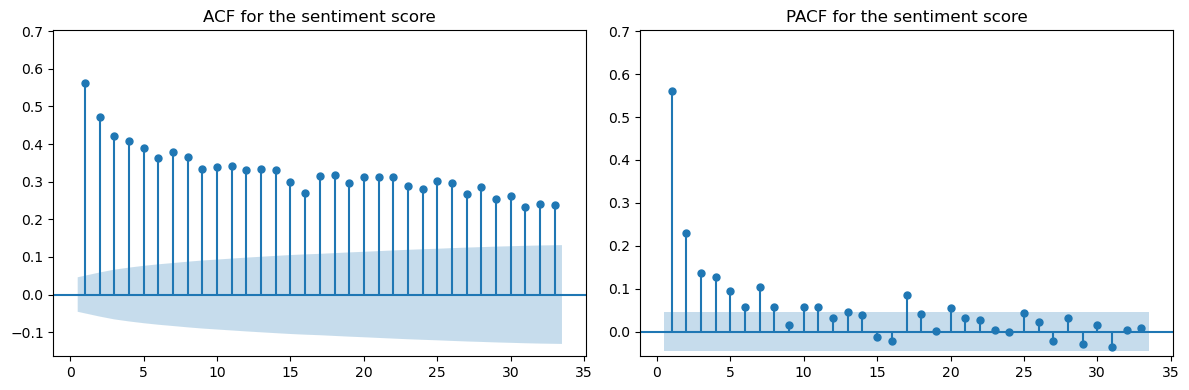

In [45]:
#Plot acf and pacf:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

# ACF plot
ax1 = plt.subplot(1, 2, 1)
plot_acf(sentiment_index_df['sentiment_score'], zero=False, auto_ylims=True, ax=ax1, title='ACF for the sentiment score')

# PACF plot
ax2 = plt.subplot(1, 2, 2)
plot_pacf(sentiment_index_df['sentiment_score'], zero=False, auto_ylims=True, ax=ax2, title='PACF for the sentiment score')

plt.tight_layout()
plt.show()


See that the underlying structure isn't clear from just observing the ACF and PACF plots, we therefore instead take the more objective approach of comparing AIC and BIC scores of different model to pick the optimal number of lags. 

### Fit ARMA for sentiment score

In [46]:
import warnings
from statsmodels.tsa.arima.model import ARIMA

# Ignore all warnings
warnings.filterwarnings("ignore")

# Determine optimal lag value with AIC and BIC for ARMA

# AIC
aic_values_arma = []

max_lag = 6

# Fit ARMA models with different lag orders
for p in range(0, max_lag + 1):
    for q in range(0, max_lag + 1):
        model_arma = ARIMA(sentiment_index_df['sentiment_score'], order=(p, 0, q))  # (p, d, q) for ARMA model
        results_arma = model_arma.fit()
        aic_values_arma.append((p, q, results_arma.aic))

# Find the lag orders with the lowest AIC
optimal_lag_aic_arma = min(aic_values_arma, key=lambda x: x[2])  # Minimum AIC tuple
print("Optimal lag orders based on AIC for ARMA model:", optimal_lag_aic_arma)

# BIC
bic_values_arma = []

# Fit ARMA models with different lag orders
for p in range(0, max_lag + 1):
    for q in range(0, max_lag + 1):
        model_arma = ARIMA(sentiment_index_df['sentiment_score'], order=(p, 0, q))
        results_arma = model_arma.fit()
        bic_values_arma.append((p, q, results_arma.bic))

# Find the lag orders with the lowest BIC
optimal_lag_bic_arma = min(bic_values_arma, key=lambda x: x[2])  # Minimum BIC tuple
print("Optimal lag orders based on BIC for ARMA model:", optimal_lag_bic_arma)

Optimal lag orders based on AIC for ARMA model: (3, 6, 8796.479484627293)


BIC indicates that the best model for the sentiment score is the ARMA(2,1), so we can now fit that model to the data.
First, we need to split our data into train and test sets, where 2015-mid 2018 is the training data and mid 2018 - 2019 is the test data.

We then implement a rolling window forecast where we forecast the sentiment one day ahead at each step. 

In [ ]:
df = sentiment_index_df.copy()
df.set_index('Date', inplace=True)
sentiment_df_train = df[:'2018-06-30'].copy()
sentiment_df_test = df['2018-07-01':].copy()

In [ ]:
y_train = ma_future_5day['sentiment_score'].copy()
y_test = ma_future_5day['sentiment_score'].copy()

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score

In [ ]:
# AIC
# Rolling window (window size is 80% of data)

import warnings
from statsmodels.tsa.arima.model import ARIMA

# Ignore all warnings
warnings.filterwarnings("ignore")


# Initialize lists to store MSE values and forecasts
res_list = []
forecast_list = []
conf = []

#initial training and test sets:
train_data = y_train.copy() # ['sentiment_score'].copy()
test_data = y_test.copy() #sentiment_df_test['sentiment_score'].copy()

for i in test_data.index:
    #print(len(train_data))
    # model = AutoReg(train_data, lags=optimal_lag_bic) # optimal lag = 10
    model = ARIMA(train_data, order=(2, 0, 1))
    model_fit = model.fit()

    #forecast = model_fit.predict(start=len(train_data), end=len(train_data))
    # forecast = model_fit.forecast(steps=1)
    get_forecast = model_fit.get_forecast(steps=1)

    forecast = get_forecast.predicted_mean
    forecast_conf = get_forecast.conf_int(alpha=0.05)

    #print(len(forecast))

    #print(forecast)
    forecast_list.append(forecast)
    conf.append(forecast_conf)

    #print(test_data[i])

    #res = test_data[i] - forecast
    #res_list.append(res)

    # Expand estimation window
    test_to_train = pd.Series([test_data[i]], index=[i])
    #print(test_to_train)
    train_data = pd.concat([train_data, test_to_train])
    train_data = train_data.iloc[1:]
    #print(len(train_data))


    #print(train_data[-5:])

# Calculate the overall average MSE
#mse = np.mean(np.square(res))
#print("Overall average MSE:", mse)

#calculate RMSE and R2:
rmse = np.sqrt(mean_squared_error(ma_future_5day['sentiment_score'], forecast_list))
r2 = r2_score(ma_future_5day['sentiment_score'], forecast_list)
print("RMSE:", rmse, "R2:", r2)

RMSE: 2.816029178040464 R2: 0.3519181593531069


In [ ]:
values = [s.iloc[0] for s in forecast_list]  # `s.iloc[0]` accesses the first value in each Series

# Create a new Series from the list of values
arma_forecast_series_sc = pd.Series(values)
arma_forecast_series_sc.index = pd.to_datetime(test_data.index)

# 0.25/75, 1.10, 74 trading days / 0.33/66, 1.22, 62 trading days
sharpe_arma_sc, df_calc_arma_sc, test_df_arma_sc, upper_arma_sc, lower_arma_sc = sharpe_correct_5day(arma_forecast_series_sc, 'sentiment_score')
print('Sharpe: ', sharpe_arma_sc)
print('Trading days: ', test_df_arma_sc['trading day'].sum())

Sharpe:  368    0.76435
Name: portfolio_value, dtype: object
Trading days:  65


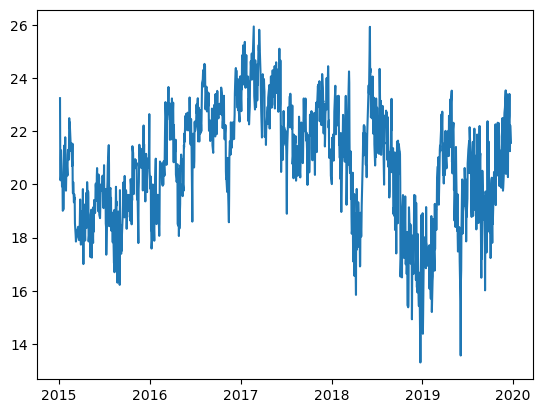

In [ ]:
plt.figure()
plt.plot(arma_forecast_series_sc)

In [ ]:
# AIC
# Rolling window (window size is 80% of data)

import warnings
from statsmodels.tsa.arima.model import ARIMA

# Ignore all warnings
warnings.filterwarnings("ignore")


# Initialize lists to store MSE values and forecasts
res_list = []
forecast_list = []
conf = []

#initial training and test sets:
train_data = y_train.copy() # ['sentiment_score'].copy()
test_data = y_test.copy() #sentiment_df_test['sentiment_score'].copy()

for i in test_data.index:
    #print(len(train_data))
    # model = AutoReg(train_data, lags=optimal_lag_bic) # optimal lag = 10
    model = ARIMA(train_data, order=(2, 0, 1))
    model_fit = model.fit()

    #forecast = model_fit.predict(start=len(train_data), end=len(train_data))
    # forecast = model_fit.forecast(steps=1)
    get_forecast = model_fit.get_forecast(steps=5)

    forecast = get_forecast.predicted_mean.mean()
    forecast_conf = get_forecast.conf_int(alpha=0.05)

    #print(len(forecast))

    #print(forecast)
    forecast_list.append(forecast)
    conf.append(forecast_conf)

    #print(test_data[i])

    #res = test_data[i] - forecast
    #res_list.append(res)

    # Expand estimation window
    test_to_train = pd.Series([test_data[i]], index=[i])
    #print(test_to_train)
    train_data = pd.concat([train_data, test_to_train])
    train_data = train_data.iloc[1:]
    #print(len(train_data))


    #print(train_data[-5:])

# Calculate the overall average MSE
#mse = np.mean(np.square(res))
#print("Overall average MSE:", mse)

#calculate RMSE and R2:
rmse = np.sqrt(mean_squared_error(ma_future_5day['sentiment_ma_next_5'], forecast_list))
r2 = r2_score(ma_future_5day['sentiment_ma_next_5'], forecast_list)
print("RMSE:", rmse, "R2:", r2)

RMSE: 1.9036631577392762 R2: 0.47356188976431246


In [ ]:
rmse = np.sqrt(mean_squared_error(ma_future_5day['sentiment_ma_next_5'], forecast_list))
r2 = r2_score(ma_future_5day['sentiment_ma_next_5'], forecast_list)
print("RMSE:", rmse, "R2:", r2)

RMSE: 1.9036631577392762 R2: 0.47356188976431246


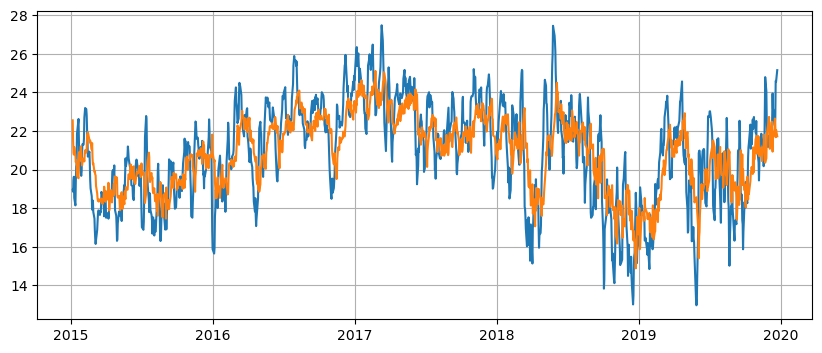

In [ ]:
plt.figure(figsize=(10,4))
plt.grid(True)
plt.plot(ma_future_5day['sentiment_ma_next_5'])
plt.plot(ma_future_5day['sentiment_ma_next_5'].index, forecast_list)

In [ ]:
# Create a new Series from the list of values
arma_forecast_series_ma = pd.Series(forecast_list)
arma_forecast_series_ma.index = pd.to_datetime(test_data.index)

sharpe_arma_ma, df_calc_arma_ma, test_df_arma_ma, upper_arma_ma, lower_arma_ma = sharpe_correct_5day(arma_forecast_series_ma, 'moving_average_10day')
print('Sharpe: ', sharpe_arma_ma)
print('Trading days: ', test_df_arma_ma['trading day'].sum())

Sharpe:  368    0.97811
Name: portfolio_value, dtype: object
Trading days:  95


#### machine learning: for 5 day moving average forward

In [ ]:
data_df.set_index('Date', inplace=True)

In [ ]:
ma_future_only = ma_future_5day.copy()
ma_future_only = pd.DataFrame(ma_future_only['sentiment_ma_next_5'])

In [ ]:
merged_df = ma_future_only.join(data_df, how='inner')

In [ ]:
original_features = merged_df.columns

original_features = original_features.drop(['r_rf', 'daily_rf'])

In [ ]:
original_features

Index(['sentiment_ma_next_5', 'r_ndq', 'Volatility', 'rf_rate',
       'sentiment_score', 'sentiment_slope', 'moving_average_10day',
       'moving_average_5day', 'moving_average_20day', 'moving_average_30day',
       'moving_average_15day', 'close_qqq', 'adj_close_qqq'],
      dtype='object')

In [ ]:
# want to use lagged values of everything but the future moving average itself

import pandas as pd

df = merged_df.copy()
# Create lagged features
for feature in original_features:
    for lag in range(1, 4):  # 3 lags
        df[f'{feature}_lag_{lag}'] = df[feature].shift(lag)

# Drop rows with NaN values that were created due to lagging
df = df.dropna()

# Split the data into training and testing sets based on the year
train_ma_df = df[:'2018-06-30']
test_ma_df = df['2018-07-01':]

# Prepare features and target variables
features_ma = [f for f in df.columns if 'lag' in f and 'sentiment_ma_next' not in f]

X_train_ma = train_ma_df[features_ma]
y_train_ma = train_ma_df['sentiment_ma_next_5']
y_train_sc = train_ma_df['sentiment_score']

X_test_ma = test_ma_df[features_ma]
y_test_ma = test_ma_df['sentiment_ma_next_5']
y_test_sc = test_ma_df['sentiment_score']

#### Sentiment score model:

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

# Models to be used
models = {
    "Random Forest": RandomForestRegressor(random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(random_state=42)
}

# Hyperparameters for tuning (simplified for rolling window example)
parameters = {
    "Random Forest": {'n_estimators': 90, 'max_depth': 3, 'min_samples_leaf' : 3},
    "Gradient Boosting": {'n_estimators': 140, 'max_depth': 4, 'learning_rate': 0.1, 'min_samples_leaf' : 4}
    # "Gradient Boosting": {'n_estimators': 120, 'max_depth': 3, 'learning_rate': 0.1, 'min_samples_leaf' : 3} worse i think 
    # "Gradient Boosting": {'n_estimators': 98, 'max_depth': 2, 'learning_rate': 0.23333333333333334} # not better than current one
}

# Initialize dictionaries to store results
model_performance_rw_sc = {}
model_predictions_rw_sc = {}

# Create test and train data set with date index
X_train_idx = X_train_ma.copy()
# X_train_idx.set_index()
y_train_idx = pd.DataFrame(y_train_sc).copy()

X_test_idx = X_test_ma.copy()
y_test_idx = pd.DataFrame(y_test_sc).copy()

# Implementing rolling window forecasting
for model_name in models:
    print('Model:  ', model_name)
    model = models[model_name]
    params = parameters[model_name]

    # Initialize storage for predictions and actuals
    predictions = []
    feature_importances_sc = []
    # actuals = y_test_idx
    #print(actuals.head())

    # Start rolling window forecast
    for i in X_test_idx.index:

        # Scale x train:
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train_idx)
        X_train_scaled_df = pd.DataFrame(X_train_scaled, columns = X_train_idx.columns)
        model.set_params(**params)
        # model.fit(X_train_scaled_df, y_train_idx)
        model.fit(X_train_scaled_df, y_train_idx.values.ravel())


        # Obtain feature importance
        importance = model.feature_importances_
        feature_importances_sc.append(importance)

        # Scale x test for the current point:
        X_test_scaled = scaler.transform(X_test_idx.loc[[i]])
        X_test_scaled_df = pd.DataFrame(X_test_scaled, columns = X_test_idx.columns)
    
        # Make a prediction for the next point
        next_point_prediction = model.predict(X_test_scaled_df)
        predictions.append(next_point_prediction[0])

        # Rolling feature window
        # X_test_to_train = pd.Series([X_test[i]], index=[i])
        X_test_to_train = X_test_idx.loc[[i]]
        print(X_test_to_train)
        X_train_idx = pd.concat([X_train_idx, X_test_to_train])
        X_train_idx = X_train_idx.iloc[1:]

        # Rolling target variable window
        y_test_to_train = y_test_idx.loc[[i]]
        print(y_test_to_train)
        y_train_idx = pd.concat([y_train_idx, y_test_to_train])
        y_train_idx = y_train_idx.iloc[1:]
    
    # Calculate performance metrics
    rmse = np.sqrt(mean_squared_error(y_test_sc, predictions))
    r2 = r2_score(y_test_sc, predictions)

    # Store results
    model_performance_rw_sc[model_name] = {'RMSE': rmse, 'R2': r2}
    model_predictions_rw_sc[model_name] = {'y_pred': predictions, 'feature_importance': feature_importances_sc}

# Output model performance
print(model_performance_rw_sc)


Model:   Random Forest
            r_ndq_lag_1  r_ndq_lag_2  r_ndq_lag_3  Volatility_lag_1  \
Date                                                                  
2018-07-02     0.002687     0.008602    -0.013599             19.26   

            Volatility_lag_2  Volatility_lag_3  rf_rate_lag_1  rf_rate_lag_2  \
Date                                                                           
2018-07-02             20.06             19.67           1.93           1.93   

            rf_rate_lag_3  sentiment_score_lag_1  ...  \
Date                                              ...   
2018-07-02           1.93              19.547577  ...   

            moving_average_30day_lag_3  moving_average_15day_lag_1  \
Date                                                                 
2018-07-02                   22.803948                   21.953136   

            moving_average_15day_lag_2  moving_average_15day_lag_3  \
Date                                                                 

In [ ]:
gb_feature_importance_sc = model_predictions_rw_sc['Gradient Boosting']['feature_importance']
gb_feature_importance_avg_sc = np.mean(gb_feature_importance_sc, axis=0)

In [ ]:
gb_sc_predictions = model_predictions_rw_sc['Gradient Boosting']['y_pred']
gb_sc_pred_series = pd.Series(gb_sc_predictions)
gb_sc_pred_series.index = pd.to_datetime(X_test_ma.index)
# 0.25/75, 1.24, 44 trading days / 0.33/66, many inputs

sharpe_gb_sc, df_calc_gb_sc, test_df_gb_sc, upper_gb_sc, lower_gb_sc = sharpe_correct_5day(gb_sc_pred_series, 'sentiment_score')
print(sharpe_gb_sc)
test_df_gb_sc['trading day'].sum()

368    1.680028
Name: portfolio_value, dtype: object


144

In [ ]:
rf_sc_predictions = model_predictions_rw_sc['Random Forest']['y_pred']
rf_sc_pred_series = pd.Series(rf_sc_predictions)
rf_sc_pred_series.index = pd.to_datetime(X_test_ma.index)
# 0.25/75, 1.24, 44 trading days / 0.33/66, many inputs

sharpe_rf_sc, df_calc_rf_sc, test_df_rf_sc, upper_rf_sc, lower_rf_sc = sharpe_correct_5day(rf_sc_pred_series, 'sentiment_score')
print(sharpe_rf_sc)
test_df_rf_sc['trading day'].sum()

368    1.141221
Name: portfolio_value, dtype: object


39

Now we have all three forecasts for the sentiment index. We can plot them all:

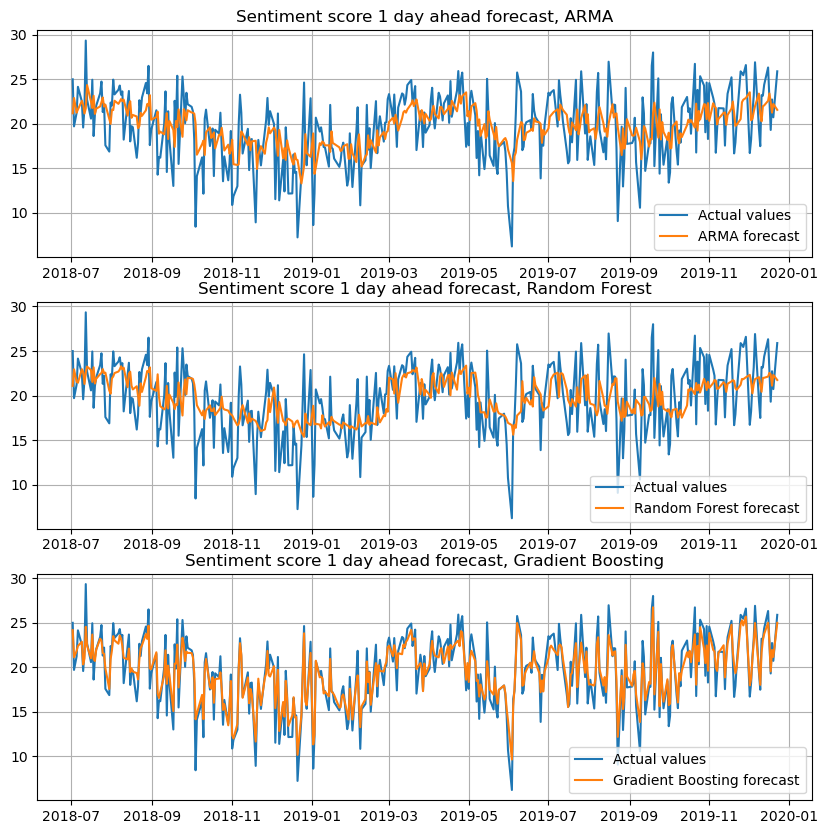

In [ ]:
plt.figure(figsize=(10,10))

#ARMA forecast:
plt.subplot(3,1,1)
plt.plot(ma_future_5day['sentiment_score']['2018-07-01':], label = 'Actual values')
plt.plot(arma_forecast_series_sc['2018-07-01':], label = 'ARMA forecast')
plt.grid(True)
plt.title('Sentiment score 1 day ahead forecast, ARMA')
plt.legend()

#RF forecast:
plt.subplot(3,1,2)
plt.plot(ma_future_5day['sentiment_score']['2018-07-01':], label = 'Actual values')
plt.plot(rf_sc_pred_series, label = 'Random Forest forecast')
plt.grid(True)
plt.title('Sentiment score 1 day ahead forecast, Random Forest')
plt.legend()

#GB forecast:
plt.subplot(3,1,3)
plt.plot(ma_future_5day['sentiment_score']['2018-07-01':], label = 'Actual values')
plt.plot(gb_sc_pred_series, label = 'Gradient Boosting forecast')
plt.grid(True)
plt.title('Sentiment score 1 day ahead forecast, Gradient Boosting')
plt.legend()

plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

# Models to be used
models = {
    "Random Forest": RandomForestRegressor(random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(random_state=42)
}

# Hyperparameters for tuning (simplified for rolling window example)
parameters = {
    "Random Forest": {'n_estimators': 90, 'max_depth': 3, 'min_samples_leaf' : 3},
    "Gradient Boosting": {'n_estimators': 120, 'max_depth': 3, 'learning_rate': 0.1, 'min_samples_leaf' : 3}
    # "Gradient Boosting": {'n_estimators': 98, 'max_depth': 2, 'learning_rate': 0.23333333333333334} # not better than current one
}

# Initialize dictionaries to store results
model_performance_rw_ma = {}
model_predictions_rw_ma = {}

# Create test and train data set with date index
X_train_idx = X_train_ma.copy()
# X_train_idx.set_index()
y_train_idx = pd.DataFrame(y_train_ma).copy()

X_test_idx = X_test_ma.copy()
y_test_idx = pd.DataFrame(y_test_ma).copy()

# Implementing rolling window forecasting
for model_name in models:
    print('Model:  ', model_name)
    model = models[model_name]
    params = parameters[model_name]

    # Initialize storage for predictions and actuals
    predictions = []
    feature_importances = []
    # actuals = y_test_idx
    #print(actuals.head())

    # Start rolling window forecast
    for i in X_test_idx.index:

        # Scale x train:
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train_idx)
        X_train_scaled_df = pd.DataFrame(X_train_scaled, columns = X_train_idx.columns)
        model.set_params(**params)
        # model.fit(X_train_scaled_df, y_train_idx)
        model.fit(X_train_scaled_df, y_train_idx.values.ravel())


        # Obtain feature importance
        importance = model.feature_importances_
        feature_importances.append(importance)

        # Scale x test for the current point:
        X_test_scaled = scaler.transform(X_test_idx.loc[[i]])
        X_test_scaled_df = pd.DataFrame(X_test_scaled, columns = X_test_idx.columns)
    
        # Make a prediction for the next point
        next_point_prediction = model.predict(X_test_scaled_df)
        predictions.append(next_point_prediction[0])

        # Rolling feature window
        # X_test_to_train = pd.Series([X_test[i]], index=[i])
        X_test_to_train = X_test_idx.loc[[i]]
        print(X_test_to_train)
        X_train_idx = pd.concat([X_train_idx, X_test_to_train])
        X_train_idx = X_train_idx.iloc[1:]

        # Rolling target variable window
        y_test_to_train = y_test_idx.loc[[i]]
        print(y_test_to_train)
        y_train_idx = pd.concat([y_train_idx, y_test_to_train])
        y_train_idx = y_train_idx.iloc[1:]
    
    # Calculate performance metrics
    rmse = np.sqrt(mean_squared_error(y_test_ma, predictions))
    r2 = r2_score(y_test_ma, predictions)

    # Store results
    model_performance_rw_ma[model_name] = {'RMSE': rmse, 'R2': r2}
    model_predictions_rw_ma[model_name] = {'y_pred': predictions, 'feature_importance': feature_importances}

# Output model performance
print(model_performance_rw_ma)


Model:   Random Forest
            r_ndq_lag_1  r_ndq_lag_2  r_ndq_lag_3  Volatility_lag_1  \
Date                                                                  
2018-07-02     0.002687     0.008602    -0.013599             19.26   

            Volatility_lag_2  Volatility_lag_3  rf_rate_lag_1  rf_rate_lag_2  \
Date                                                                           
2018-07-02             20.06             19.67           1.93           1.93   

            rf_rate_lag_3  sentiment_score_lag_1  ...  \
Date                                              ...   
2018-07-02           1.93              19.547577  ...   

            moving_average_30day_lag_3  moving_average_15day_lag_1  \
Date                                                                 
2018-07-02                   22.803948                   21.953136   

            moving_average_15day_lag_2  moving_average_15day_lag_3  \
Date                                                                 

In [ ]:
gb_feature_importance = model_predictions_rw_ma['Gradient Boosting']['feature_importance']
gb_feature_importance_avg = np.mean(gb_feature_importance, axis=0)

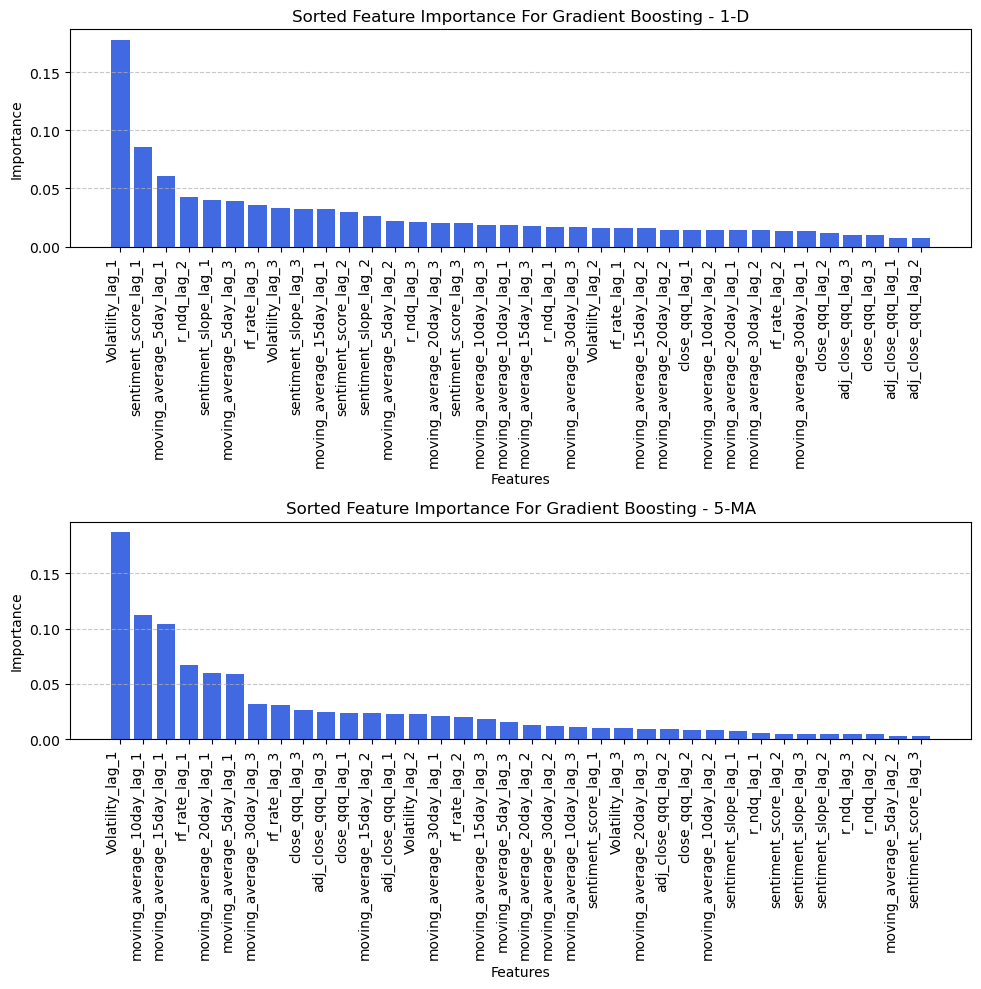

In [ ]:
# Assuming that `gb_feature_importance_avg_2` contains the importance scores in the same order as `labels`
# Combine labels and importance scores into a list of tuples

labels = X_train_ma.columns

feature_importance = list(zip(labels, gb_feature_importance_avg))
feature_importance_sc = list(zip(labels, gb_feature_importance_avg_sc))

# Sort the list of tuples by importance scores in descending order
sorted_features = sorted(feature_importance, key=lambda x: x[1], reverse=True)
sorted_features_sc = sorted(feature_importance_sc, key=lambda x: x[1], reverse=True)

# Extract sorted features and their corresponding scores
sorted_labels, sorted_importances = zip(*sorted_features)
sorted_labels_sc, sorted_importances_sc = zip(*sorted_features_sc)

# Plot the sorted features as a bar plot
plt.figure(figsize=(10, 10))
plt.subplot(2,1,1)
plt.bar(sorted_labels_sc, sorted_importances_sc, color='royalblue')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Sorted Feature Importance For Gradient Boosting - 1-D')
plt.xticks(rotation=90, ha="right")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.subplot(2,1,2)
plt.bar(sorted_labels, sorted_importances, color='royalblue')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Sorted Feature Importance For Gradient Boosting - 5-MA')
plt.xticks(rotation=90, ha="right")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In [ ]:
gb_ma_predictions = model_predictions_rw_ma['Gradient Boosting']['y_pred']
gb_ma_pred_series = pd.Series(gb_ma_predictions)
gb_ma_pred_series.index = pd.to_datetime(X_test_ma.index)
# 0.25/75, 1.24, 44 trading days / 0.33/66, many inputs

sharpe_gb_ma, df_calc_gb_ma, test_df_gb_ma, upper_gb_ma, lower_gb_ma = sharpe_correct_5day(gb_ma_pred_series, 'moving_average_10day')
print(sharpe_gb_ma)
test_df_gb_ma['trading day'].sum()

368    3.792723
Name: portfolio_value, dtype: object


52

In [ ]:
rf_ma_predictions = model_predictions_rw_ma['Random Forest']['y_pred']
rf_ma_pred_series = pd.Series(rf_ma_predictions)
rf_ma_pred_series.index = pd.to_datetime(X_test_ma.index)
# 0.25/75, 1.24, 44 trading days / 0.33/66, many inputs

sharpe_rf_ma, df_calc_rf_ma, test_df_rf_ma, upper_rf_ma, lower_rf_ma = sharpe_correct_5day(rf_ma_pred_series, 'moving_average_10day')
print(sharpe_rf_ma)
test_df_rf_ma['trading day'].sum()

368    1.782457
Name: portfolio_value, dtype: object


60

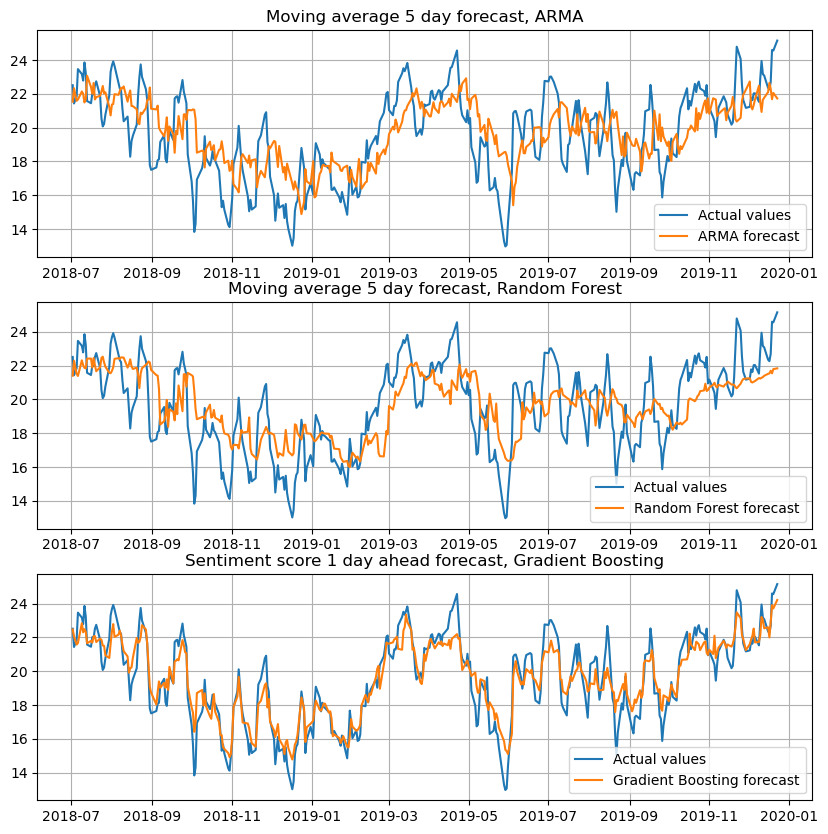

In [ ]:
plt.figure(figsize=(10,10))

#ARMA forecast:
plt.subplot(3,1,1)
plt.plot(ma_future_5day['sentiment_ma_next_5']['2018-07-01':], label = 'Actual values')
plt.plot(arma_forecast_series_ma['2018-07-01':], label = 'ARMA forecast')
plt.grid(True)
plt.title('Moving average 5 day forecast, ARMA')
plt.legend()

#RF forecast:
plt.subplot(3,1,2)
plt.plot(ma_future_5day['sentiment_ma_next_5']['2018-07-01':], label = 'Actual values')
plt.plot(rf_ma_pred_series, label = 'Random Forest forecast')
plt.grid(True)
plt.title('Moving average 5 day forecast, Random Forest')
plt.legend()

#GB forecast:
plt.subplot(3,1,3)
plt.plot(ma_future_5day['sentiment_ma_next_5']['2018-07-01':], label = 'Actual values')
plt.plot(gb_ma_pred_series, label = 'Gradient Boosting forecast')
plt.grid(True)
plt.title('Sentiment score 1 day ahead forecast, Gradient Boosting')
plt.legend()

plt.show()

In [ ]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit
#{'n_estimators': 90, 'max_depth': 3, 'min_samples_leaf' : 3}
# Define the parameter grid
rf_param_grid = {
    'n_estimators': [90, 200, 250, 1000],
    'max_depth': [3, 5, 7],
    'min_samples_leaf': [3, 5, 6, 7]
}

# Setup the grid search
rf_grid_search = RandomizedSearchCV(RandomForestRegressor(random_state=42, criterion='friedman_mse'), rf_param_grid, cv=TimeSeriesSplit(), scoring='neg_mean_squared_error')
rf_grid_search.fit(X_train_ma, y_train_ma)

# Best Random Forest model
rf_best_model = rf_grid_search.best_estimator_

pred = rf_best_model.predict(X_test_ma)
print(r2_score(y_test_ma, pred))

pred = pd.Series(pred)
pred.index = y_test_ma.index
final_prediction = pred[~pred.index.isin(pred.index.difference(portfolio_df_sent.index))]

0.1642876588432688


In [ ]:
rf_best_model.get_params

<bound method BaseEstimator.get_params of RandomForestRegressor(criterion='friedman_mse', max_depth=3, min_samples_leaf=3,
                      n_estimators=1000, random_state=42)>

combos to try with rolling window: RandomForestRegressor(max_depth=3, min_samples_leaf=6, n_estimators=200, random_state=42)
RandomForestRegressor(max_depth=3, min_samples_leaf=5, n_estimators=200, random_state=42)

RandomForestRegressor(criterion='friedman_mse', max_depth=3, min_samples_leaf=3,
                      n_estimators=1000, random_state=42)

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor


predictions_rf = []
feature_importances_rf = []

# Create test and train data set with date index
X_train_idx = X_train_ma.copy()
# X_train_idx.set_index()
y_train_idx = pd.DataFrame(y_train_ma).copy()

X_test_idx = X_test_ma.copy()
y_test_idx = pd.DataFrame(y_test_ma).copy()

# actuals = y_test_idx
#print(actuals.head())

# Start rolling window forecast
for i in X_test_idx.index:
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_idx)
    X_train_scaled_df = pd.DataFrame(X_train_scaled, columns = X_train_idx.columns)
    model = RandomForestRegressor(criterion='friedman_mse', max_depth=3, min_samples_leaf=3, n_estimators=1000, random_state=42)
        # model.fit(X_train_scaled_df, y_train_idx)
    model.fit(X_train_scaled_df, y_train_idx.values.ravel())


        # Obtain feature importance
    importance = model.feature_importances_
    feature_importances_rf.append(importance)

        # Scale x test for the current point:
    X_test_scaled = scaler.transform(X_test_idx.loc[[i]])
    X_test_scaled_df = pd.DataFrame(X_test_scaled, columns = X_test_idx.columns)
    
        # Make a prediction for the next point
    next_point_prediction = model.predict(X_test_scaled_df)
    predictions_rf.append(next_point_prediction[0])

        # Rolling feature window
        # X_test_to_train = pd.Series([X_test[i]], index=[i])
    X_test_to_train = X_test_idx.loc[[i]]
    print(X_test_to_train)
    X_train_idx = pd.concat([X_train_idx, X_test_to_train])
    X_train_idx = X_train_idx.iloc[1:]

        # Rolling target variable window
    y_test_to_train = y_test_idx.loc[[i]]
    print(y_test_to_train)
    y_train_idx = pd.concat([y_train_idx, y_test_to_train])
    y_train_idx = y_train_idx.iloc[1:]
    
    # Calculate performance metrics
    rmse_rf = np.sqrt(mean_squared_error(y_test_ma, predictions_rf))
    r2_rf = r2_score(y_test_ma, predictions_rf)

    
# Output model performance
print('RMSE: ',rmse_rf, 'R2: ', r2_rf)


            r_ndq_lag_1  r_ndq_lag_2  r_ndq_lag_3  Volatility_lag_1  \
Date                                                                  
2018-07-02     0.002687     0.008602    -0.013599             19.26   

            Volatility_lag_2  Volatility_lag_3  rf_rate_lag_1  rf_rate_lag_2  \
Date                                                                           
2018-07-02             20.06             19.67           1.93           1.93   

            rf_rate_lag_3  sentiment_score_lag_1  ...  \
Date                                              ...   
2018-07-02           1.93              19.547577  ...   

            moving_average_30day_lag_3  moving_average_15day_lag_1  \
Date                                                                 
2018-07-02                   22.803948                   21.953136   

            moving_average_15day_lag_2  moving_average_15day_lag_3  \
Date                                                                 
2018-07-02            

In [ ]:
r2_score(ma_future_5day['sentiment_ma_next_5']['2018-07-01':], predictions_rf)

0.39597915483781543

In [ ]:
rmse_rf = np.sqrt(mean_squared_error(y_test_ma, predictions_rf))
r2_rf = r2_score(y_test_ma, predictions_rf)


# Output model performance
print('RMSE: ',rmse_rf, 'R2: ', r2_rf)

RMSE:  2.04986120727732 R2:  0.39597915483781543


In [ ]:
rf_ma_pred_series = pd.Series(predictions_rf)
rf_ma_pred_series.index = pd.to_datetime(X_test_ma.index)
# 0.25/75, 1.24, 44 trading days / 0.33/66, many inputs

sharpe_rf_ma, df_calc_rf_ma, test_df_rf_ma, upper_rf_ma, lower_rf_ma = sharpe_correct_5day(rf_ma_pred_series, 'moving_average_10day')
print(sharpe_rf_ma)
test_df_rf_ma['trading day'].sum()

368    1.537942
Name: portfolio_value, dtype: object


57

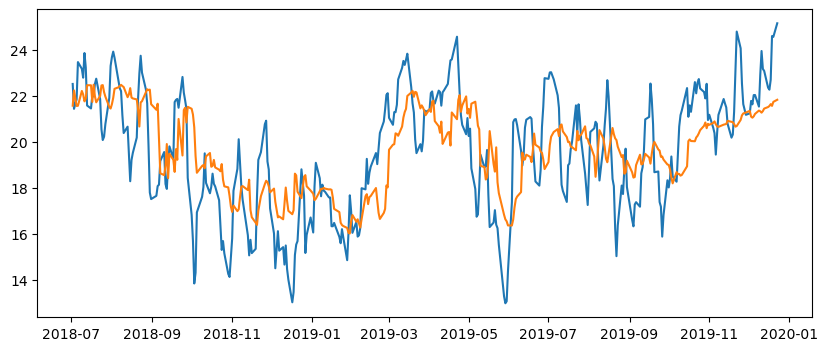

In [ ]:
plt.figure(figsize=(10, 4))
plt.plot(ma_future_5day['sentiment_ma_next_5']['2018-07-01':])
plt.plot(rf_ma_pred_series)

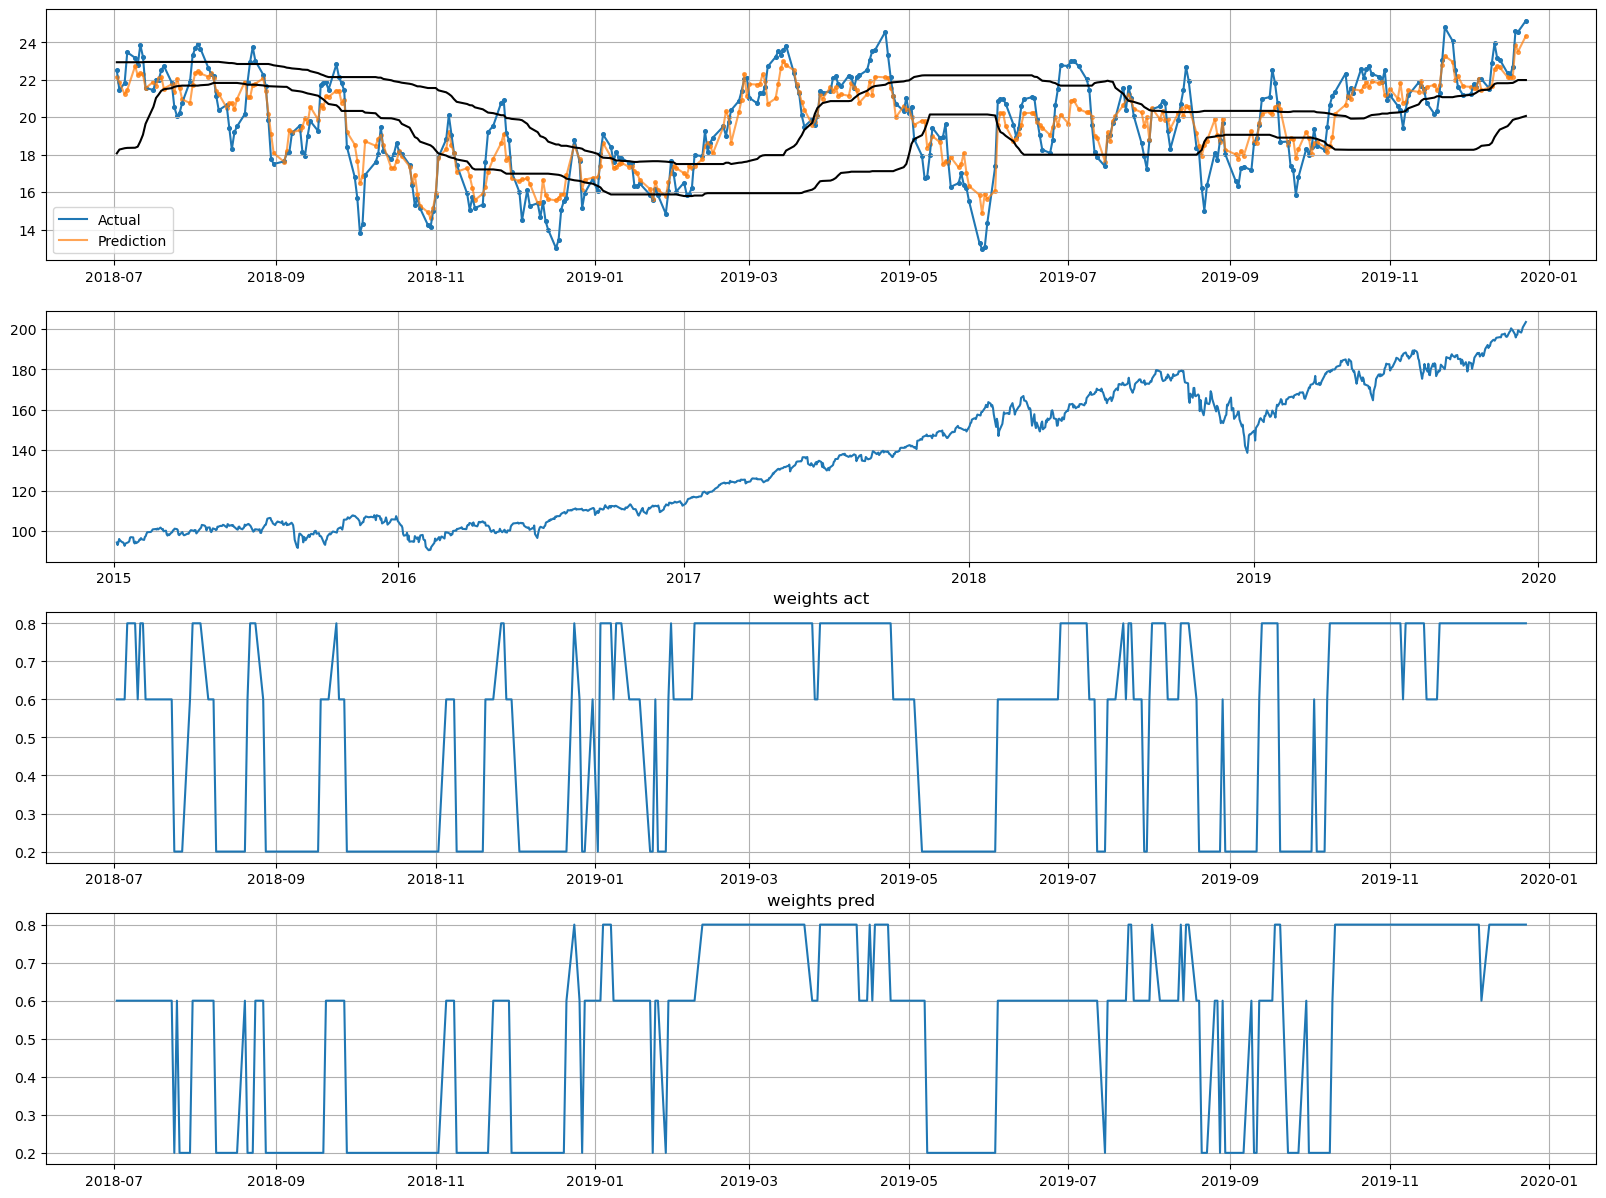

In [ ]:
weights_act = test_df_act_future_ma_5day['w_ndq']
weights_pred = test_df_gb_ma['w_ndq']

plt.figure(figsize=(20, 15))
plt.subplot(4, 1, 1)
plt.plot(y_test_ma, label = 'Actual')
plt.scatter(x=y_test_ma.index, y=y_test_ma, s=7)
plt.plot(gb_ma_pred_series, alpha=0.7, label = 'Prediction')
plt.scatter(x=gb_ma_pred_series.index, y=gb_ma_pred_series, s=7, alpha=0.7)
plt.plot(upper_gb_ma['2018-07-01':], color = 'black')
plt.plot(lower_gb_ma['2018-07-01':], color = 'black')
plt.grid(True)
plt.legend()
plt.subplot(4, 1, 2)
plt.plot(QQQ_df_weekdays_test['Adj Close'])
plt.grid(True)

plt.subplot(4, 1, 3)
plt.plot(weights_act)
plt.grid(True)
plt.title('weights act')
plt.subplot(4, 1, 4)
plt.plot(weights_pred)
plt.grid(True)
plt.title('weights pred')

plt.show()

-----------------
Random plots that might be good to recreate:

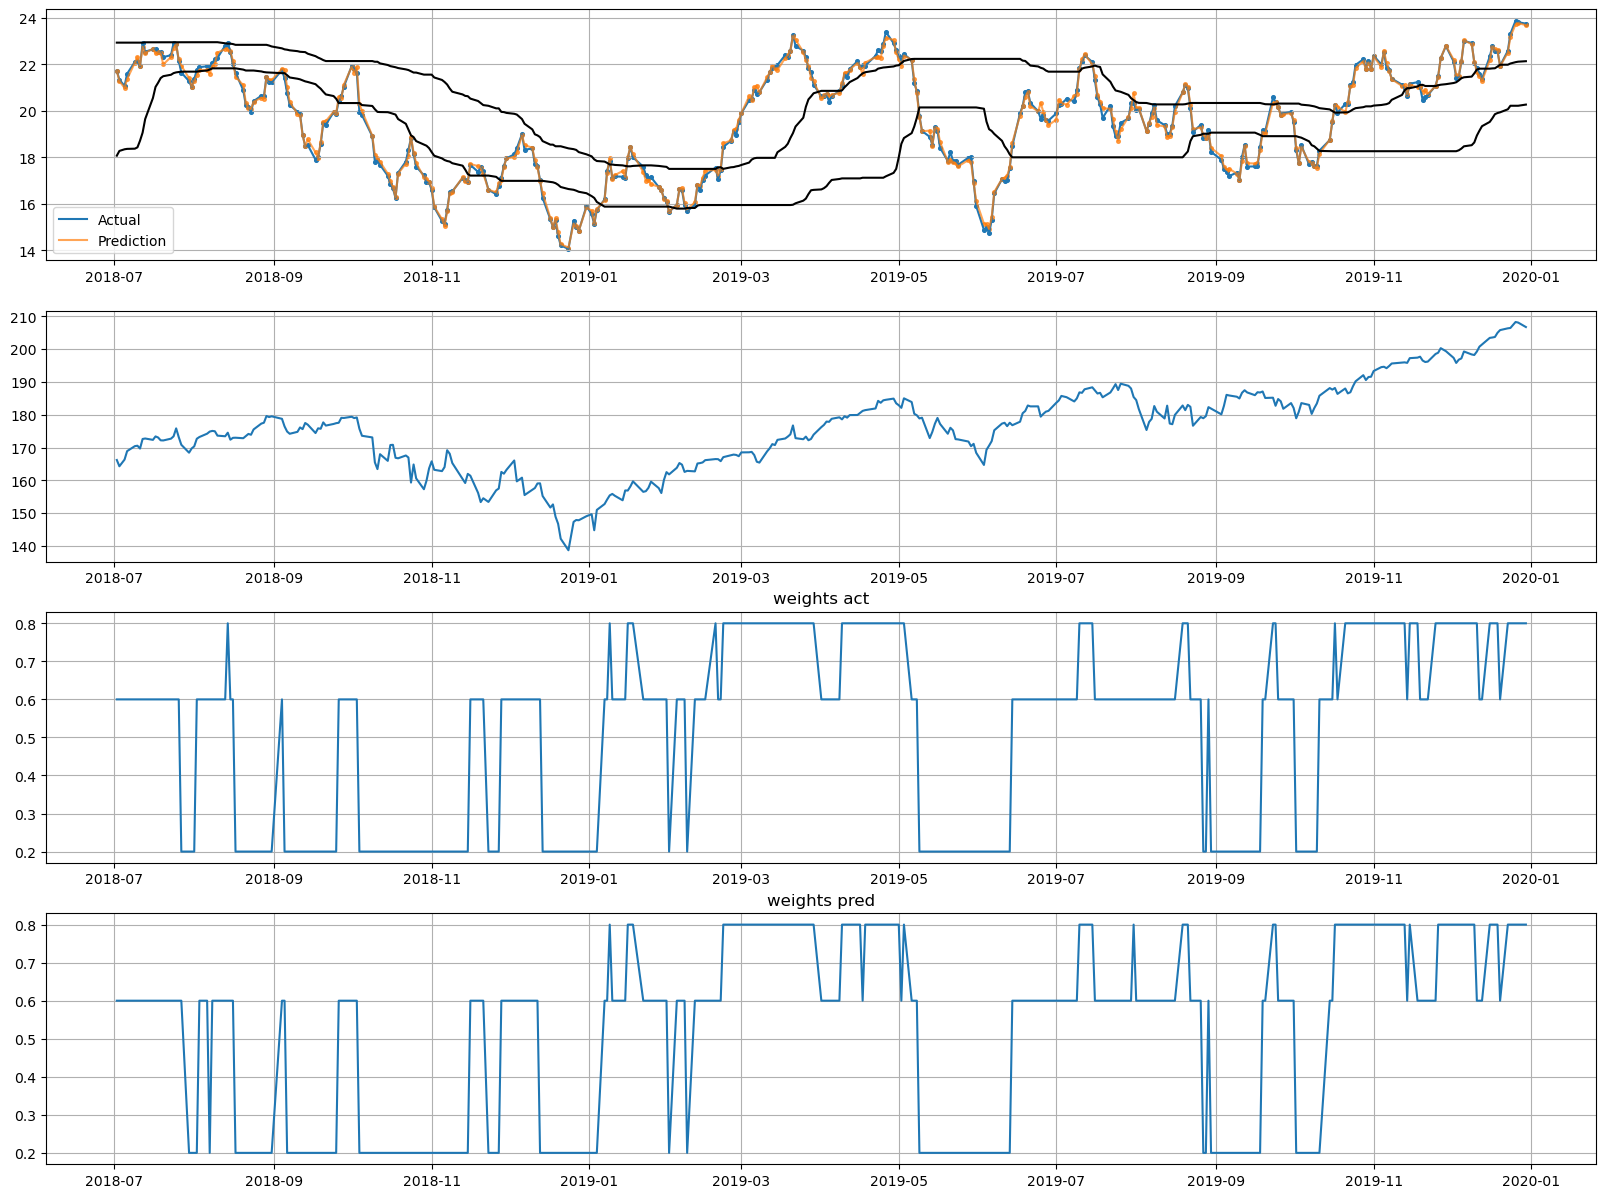

In [ ]:
weights_act = test_df_act_10d_ma['w_ndq']
weights_pred = test_df_gb_ma_4['w_ndq']

QQQ_df = price_df.copy()
QQQ_df.set_index('Date', inplace=True)
QQQ_df_weekdays_test = QQQ_df[~QQQ_df.index.isin(QQQ_df.index.difference(portfolio_df_sent_test.index))]



plt.figure(figsize=(20, 15))
plt.subplot(4, 1, 1)
plt.plot(y_test_ma_4, label = 'Actual')
plt.scatter(x=y_test_ma_4.index, y=y_test_ma_4, s=7)
plt.plot(gb_ma_pred_series_4, alpha=0.7, label = 'Prediction')
plt.scatter(x=gb_ma_pred_series_4.index, y=gb_ma_pred_series_4, s=7, alpha=0.7)
plt.plot(upper_gb_ma_4['2018-07-01':], color = 'black')
plt.plot(lower_gb_ma_4['2018-07-01':], color = 'black')
plt.grid(True)
plt.legend()
plt.subplot(4, 1, 2)
plt.plot(QQQ_df_weekdays_test['Adj Close'])
plt.grid(True)

plt.subplot(4, 1, 3)
plt.plot(weights_act)
plt.grid(True)
plt.title('weights act')
plt.subplot(4, 1, 4)
plt.plot(weights_pred)
plt.grid(True)
plt.title('weights pred')

plt.show()

--------------------------

Text(0.5, 1.0, 'Market regime classification \n 10 day moving average of sentiment index')

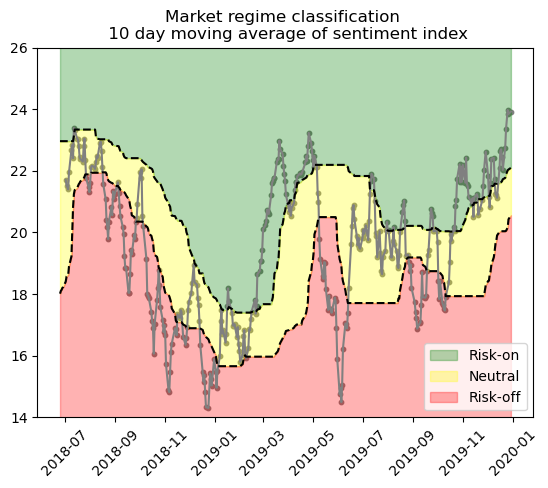

In [ ]:
plt.plot(portfolio_df_sent_test['moving_average_10day'], color = 'gray')
plt.scatter(portfolio_df_sent_test.index, portfolio_df_sent_test['moving_average_10day'], color = 'gray', s = 10)
plt.plot(portfolio_df_sent['2018-04-01':]['moving_average_10day'].rolling(60).quantile(0.75), color = 'black', linestyle='--')
plt.plot(portfolio_df_sent['2018-04-01':]['moving_average_10day'].rolling(60).quantile(0.25),color = 'black', linestyle='--')
plt.fill_between(x = portfolio_df_sent['2018-04-01':].index, y1 = portfolio_df_sent['2018-04-01':]['moving_average_10day'].rolling(60).quantile(0.75), y2 = 28, alpha = 0.3, color = 'green', label='Risk-on')
plt.fill_between(x = portfolio_df_sent['2018-04-01':].index, y1 = portfolio_df_sent['2018-04-01':]['moving_average_10day'].rolling(60).quantile(0.25), y2 =portfolio_df_sent['2018-04-01':]['moving_average_10day'].rolling(60).quantile(0.75), alpha = 0.3, color = 'yellow', label='Neutral')
plt.fill_between(x = portfolio_df_sent['2018-04-01':].index, y1 = 12.5, y2 = portfolio_df_sent['2018-04-01':]['moving_average_10day'].rolling(60).quantile(0.25), alpha = 0.3, color = 'red', label='Risk-off')
plt.ylim(14, 26)
plt.xticks(rotation=45) 
plt.legend(loc='lower right')
plt.title('Market regime classification \n 10 day moving average of sentiment index')
#plt.text(18075, 13, 'Risk-off', backgroundcolor = 'red')
#plt.text(18075, 19, 'Neutral', backgroundcolor = 'yellow')
#plt.text(18075, 23, 'Risk-on', backgroundcolor = 'green')

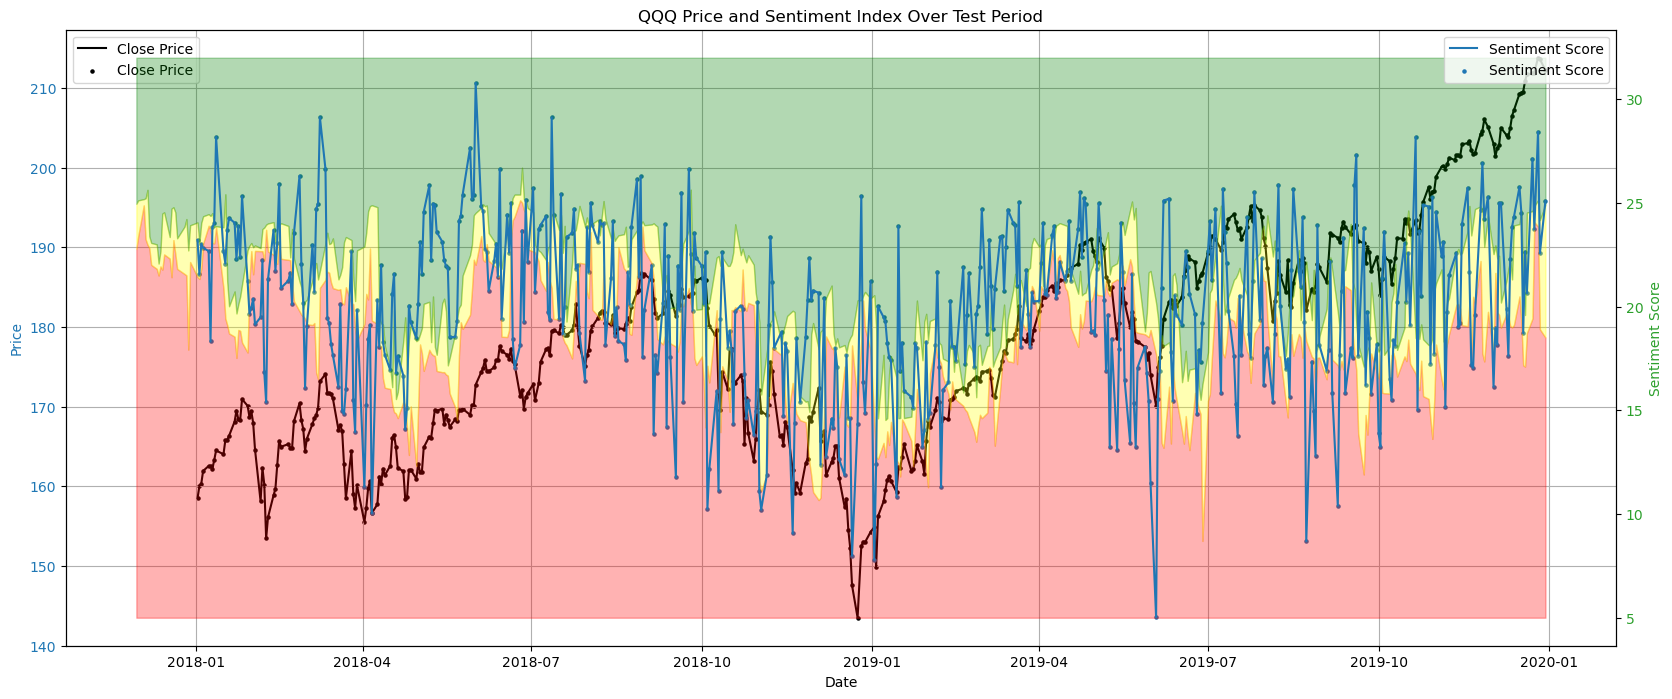

In [ ]:
import matplotlib.pyplot as plt

# Create a figure and a single subplot
fig, ax1 = plt.subplots(figsize=(20, 8))

# Plotting the price data on the first y-axis
ax1.set_xlabel('Date')  # Set the x-axis label
ax1.set_ylabel('Price', color='tab:blue')  # Set the y-axis label and color for the price data
#ax1.plot(price_df['Open']['2019-01-01':], color='tab:blue', label='Open Price')  # Plot the open prices
ax1.plot(price_df['Close']['2018-01-01':], color='black', label='Close Price')  # Plot the close prices
ax1.scatter(price_df['Close']['2018-01-01':].index, price_df['Close']['2018-01-01':], s=5, color='black', label='Close Price')  # Plot the close prices
ax1.tick_params(axis='y', labelcolor='tab:blue')  # Set the tick color for the y-axis
ax1.legend(loc='upper left')  # Place a legend in the upper left corner
ax1.grid(True)  # Enable grid
ax1.set_title('QQQ Price and Sentiment Index Over Test Period')  # Set title for the plot

# Creating a second y-axis that shares the same x-axis
ax2 = ax1.twinx()  # Instantiate a second axes that shares the same x-axis
ax2.set_ylabel('Sentiment Score', color='tab:green')  # Set the y-axis label and color for the sentiment data
ax2.plot(portfolio_df_sent['sentiment_score']['2018-01-01':], color='tab:blue', label='Sentiment Score')  # Plot the sentiment score
ax2.scatter(portfolio_df_sent['sentiment_score']['2018-01-01':].index, portfolio_df_sent['sentiment_score']['2018-01-01':], s=5, color='tab:blue', label='Sentiment Score')  # Plot the sentiment score
ax2.tick_params(axis='y', labelcolor='tab:green')  # Set the tick color for the y-axis
ax2.legend(loc='upper right')  # Place a legend in the upper right corner
plt.fill_between(x = portfolio_df_sent['2017-11-01':].index, y1 = 5, y2 = portfolio_df_sent['2017-11-01':]['sentiment_score'].shift(1).rolling(20).apply(lambda x: weighted_quantile(x, quantile=0.33), raw=True), alpha = 0.3, color = 'red', label='Risk-off')
plt.fill_between(x = portfolio_df_sent['2017-11-01':].index, y1 = portfolio_df_sent['2017-11-01':]['sentiment_score'].shift(1).rolling(20).apply(lambda x: weighted_quantile(x, quantile=0.33), raw=True), y2 =portfolio_df_sent['2017-11-01':]['sentiment_score'].shift(1).rolling(20).apply(lambda x: weighted_quantile(x, quantile=0.66), raw=True), alpha = 0.3, color = 'yellow', label='Neutral')
plt.fill_between(x = portfolio_df_sent['2017-11-01':].index, y1 = portfolio_df_sent['2017-11-01':]['sentiment_score'].shift(1).rolling(20).apply(lambda x: weighted_quantile(x, quantile=0.66), raw=True), y2 = 32, alpha = 0.3, color = 'green', label='Risk-on')

# Show the plot
plt.show()

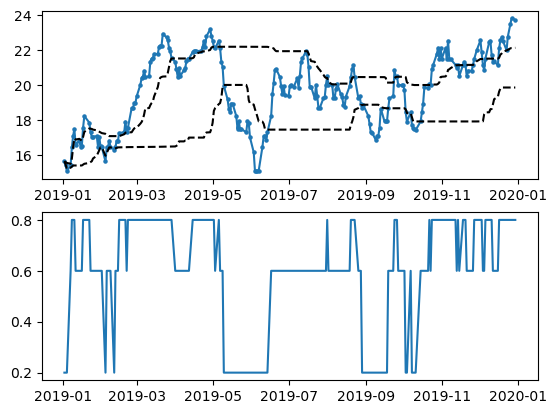

In [ ]:
plt.figure()
plt.subplot(2,1,1)
plt.plot(final_prediction)
plt.scatter(final_prediction.index, final_prediction, s = 5)
plt.plot(final_prediction.index, upper, color = 'black', linestyle = '--')
plt.plot(final_prediction.index, lower, color = 'black', linestyle = '--')
plt.subplot(2,1,2)
plt.plot(portfolio_df_sent_test['w_ndq'])
plt.show()